# Post-analysis of posterior distribution: Weighted Ridge Regression for adjusting posterior estimates of $\theta$ from the SMC-ABC with importance sampling.

NB: Note that, in contrast to the ordinary least square regression, ridge regression is highly affected by the scale of the predictors. Therefore, it is better to standardize (i.e., scale) the predictors before applying the ridge regression (James et al. 2014), so that all the predictors are on the same scale.

To implement the Weighted Ridge Regression for a model parameter $\theta^{(\iota)}$=$(\theta_1^{(\iota)},\theta_2^{(\iota)} \cdots,\theta_{\eta}^{(\iota)})$ during posterior-post analyses, we minimise loss function

$$
\mathcal{L}_{\text{ridge}}^{(\iota)}=\sum_{i=1}^{\eta} \left \{ \theta_i^{(\iota)} - \alpha^{(\iota)} - \frac{1}{m}\sum_{j}^{m}(S_{ij}-S_j)^{\prime} \beta^{(\iota)} \right \}^2 \mathbf{Ker f}_{\delta}(|| S_i-S ||)+ k|| \beta^{(\iota)}||_{2}^2
$$

where $|| \beta^{(\iota)}||_{2}^2= \sum \limits_{j=1}^{p}\beta_{j}^{(\iota)2}$, $\mathbf{Kerf}_{\delta}$  is a kernel function (possibly Gaussian kernel due to computational efficiency) with bandwidth $\delta$, and $m is the total number of observed fish.

and 

$$
\theta_i^{(\iota)}= \alpha^{(\iota)} +X^{\prime} \beta^{(\iota)} + \epsilon=\alpha^{(\iota)} +\frac{1}{m}\sum_{j}^{m}(S_{ij}-S_j)^{\prime} \beta^{(\iota)} + \epsilon \quad \text{for} \quad i=1,2,\cdots,M; \quad \iota=1,2,\cdots,\rho 
$$

and $\epsilon$ is assumed to be heteroskedastic with multicollinearity between predictor variables/summary statistics.

The solution to the above minimising equation with L2-norm is 


$$
\hat{\beta}_{p \times 1}^{(\iota)}= (X_{p \times \eta}^{\prime}W_{\eta \times \eta}X_{\eta \times p}+kI_{p \times p})^{-1}X_{p \times \eta}^{\prime}W_{\eta \times \eta} \theta_{p \times 1} \quad \text{for} \quad \iota=1,2,\cdots,\rho 
$$

and the posterior adjustment ($\hat{\alpha}$, the regression intercept) is given by


$$
\hat{\alpha}^{(\iota)}= \bar{\theta}^{(\iota)}- \bar{X} \hat{\beta}^{(\iota)}
$$


Prior to the posterior adjustments, the dependent variable ($\theta^{(\iota)}$) and predictors given by the design matrix $X$ are standardised in two stages:

**Stage 1:** $X= X- \eta \bar{X}$     and     $\theta^{(\iota)}=\theta^{(\iota)}-\bar{\theta}^{(\iota)}$

**Stage 2:** $X= \sqrt{\omega}X$      and      $\theta^{(\iota)}= \sqrt{\omega}\theta^{(\iota)}$


where $\bar{\theta}^{(\iota)}= \frac{ \sum \limits_{i=1}^{\eta} \omega_i \theta_i^{(\iota)}}    {\sum \limits_{i=1}^{\eta} \omega_i}$ and $\bar{X}= \frac{ \omega_i}   {\sum \limits_{i=1}^{\eta} \omega_i}X$ and $\omega= diag(W)$.

$W$ is a diagonal weighting matrix with the $i$th diagonal element given by $\mathbf{Kerf}_{\delta}(|| S_i-S ||)$ (based on a Gaussian kernel and a weighted distance measure); and $\hat{\alpha}$ is the adjusted posterior mean estimates of the vector $\theta$, $\eta$ is the number of posterior samples, $k$ is the penalising parameter/bias, $\rho$ is the dimension of the model parameters, and $p$ is the summary statistics dimension. The glmnet package in R was used to obtain the optimal value of $k$ (among a range of values from 0.01 to 100) that achieve the least predictive error before posterior adjustments.

In [20]:
#Loading packages
library(transport) #For Wassertein distance computation
library(parallel) # For parallizing R codes
RNGkind("L'Ecuyer-CMRG") #Dealing with distinct seed value in R
#library(markovchain)
#library(diagram)
library('latex2exp') #For adding LaTeX symbols to R plots
library(compiler)# byte code compilation
library(data.table)
library("maxLik")#for maximum likelihood estimation/optimization
library("R.utils")
library(MASS)
library("kader")
library("PerformanceAnalytics")
library(glmnet)
library("kedd")
library(bayestestR)#for credible interval

In [3]:
#set working directory 
setwd(paste0("/home/clement/Documents/Regression_adjust_SimulationModel_new"))

# Plotting posterior distribution and priors

In [4]:
#Importing posterior densities from Weighted-iterative ABC with Sequential Monte Carlo with importance sampling
draws<- c(500)
density_post<-NULL

for(n in draws){ 
    
ABC_iterations<-11
number_of_parameters<- 23
x <- seq(from = -10, to = 7, length.out = 256)#range of prior distribution
density_post[[n]]<- list()
for(j in 1:ABC_iterations) {
    density_post[[n]][[j]]<-read.csv(file=paste0("density_post_",j,"_",n,".csv"))
    density_post[[n]][[j]]<-density_post[[n]][[j]][,-1]
          }
}

In [5]:
parameter_labels=c(expression(paste("b"[11])),expression(paste("b"[12])),
                   expression(paste("b"[21])),expression(paste("b"[22])), 
                   expression(paste("b"[31])),expression(paste("b"[32])),
                   expression(paste("d"[11])),expression(paste("d"[12])),
                   expression(paste("d"[21])),expression(paste("d"[22])), 
                   expression(paste("d"[31])),expression(paste("d"[32])),
                   expression(paste("m")),  expression(paste("r")),
                   expression(paste("r"[1])),expression(paste("r"[2])),
                   expression(paste("r"[3])),expression(paste("s")),
                   expression(paste("s"[1])),expression(paste(epsilon[1])),
                   expression(paste(epsilon[2])),expression(paste(epsilon[3])),
                   expression(paste(kappa)))
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res = 300) #Setting plot size

# Density plot on log scale at N=500

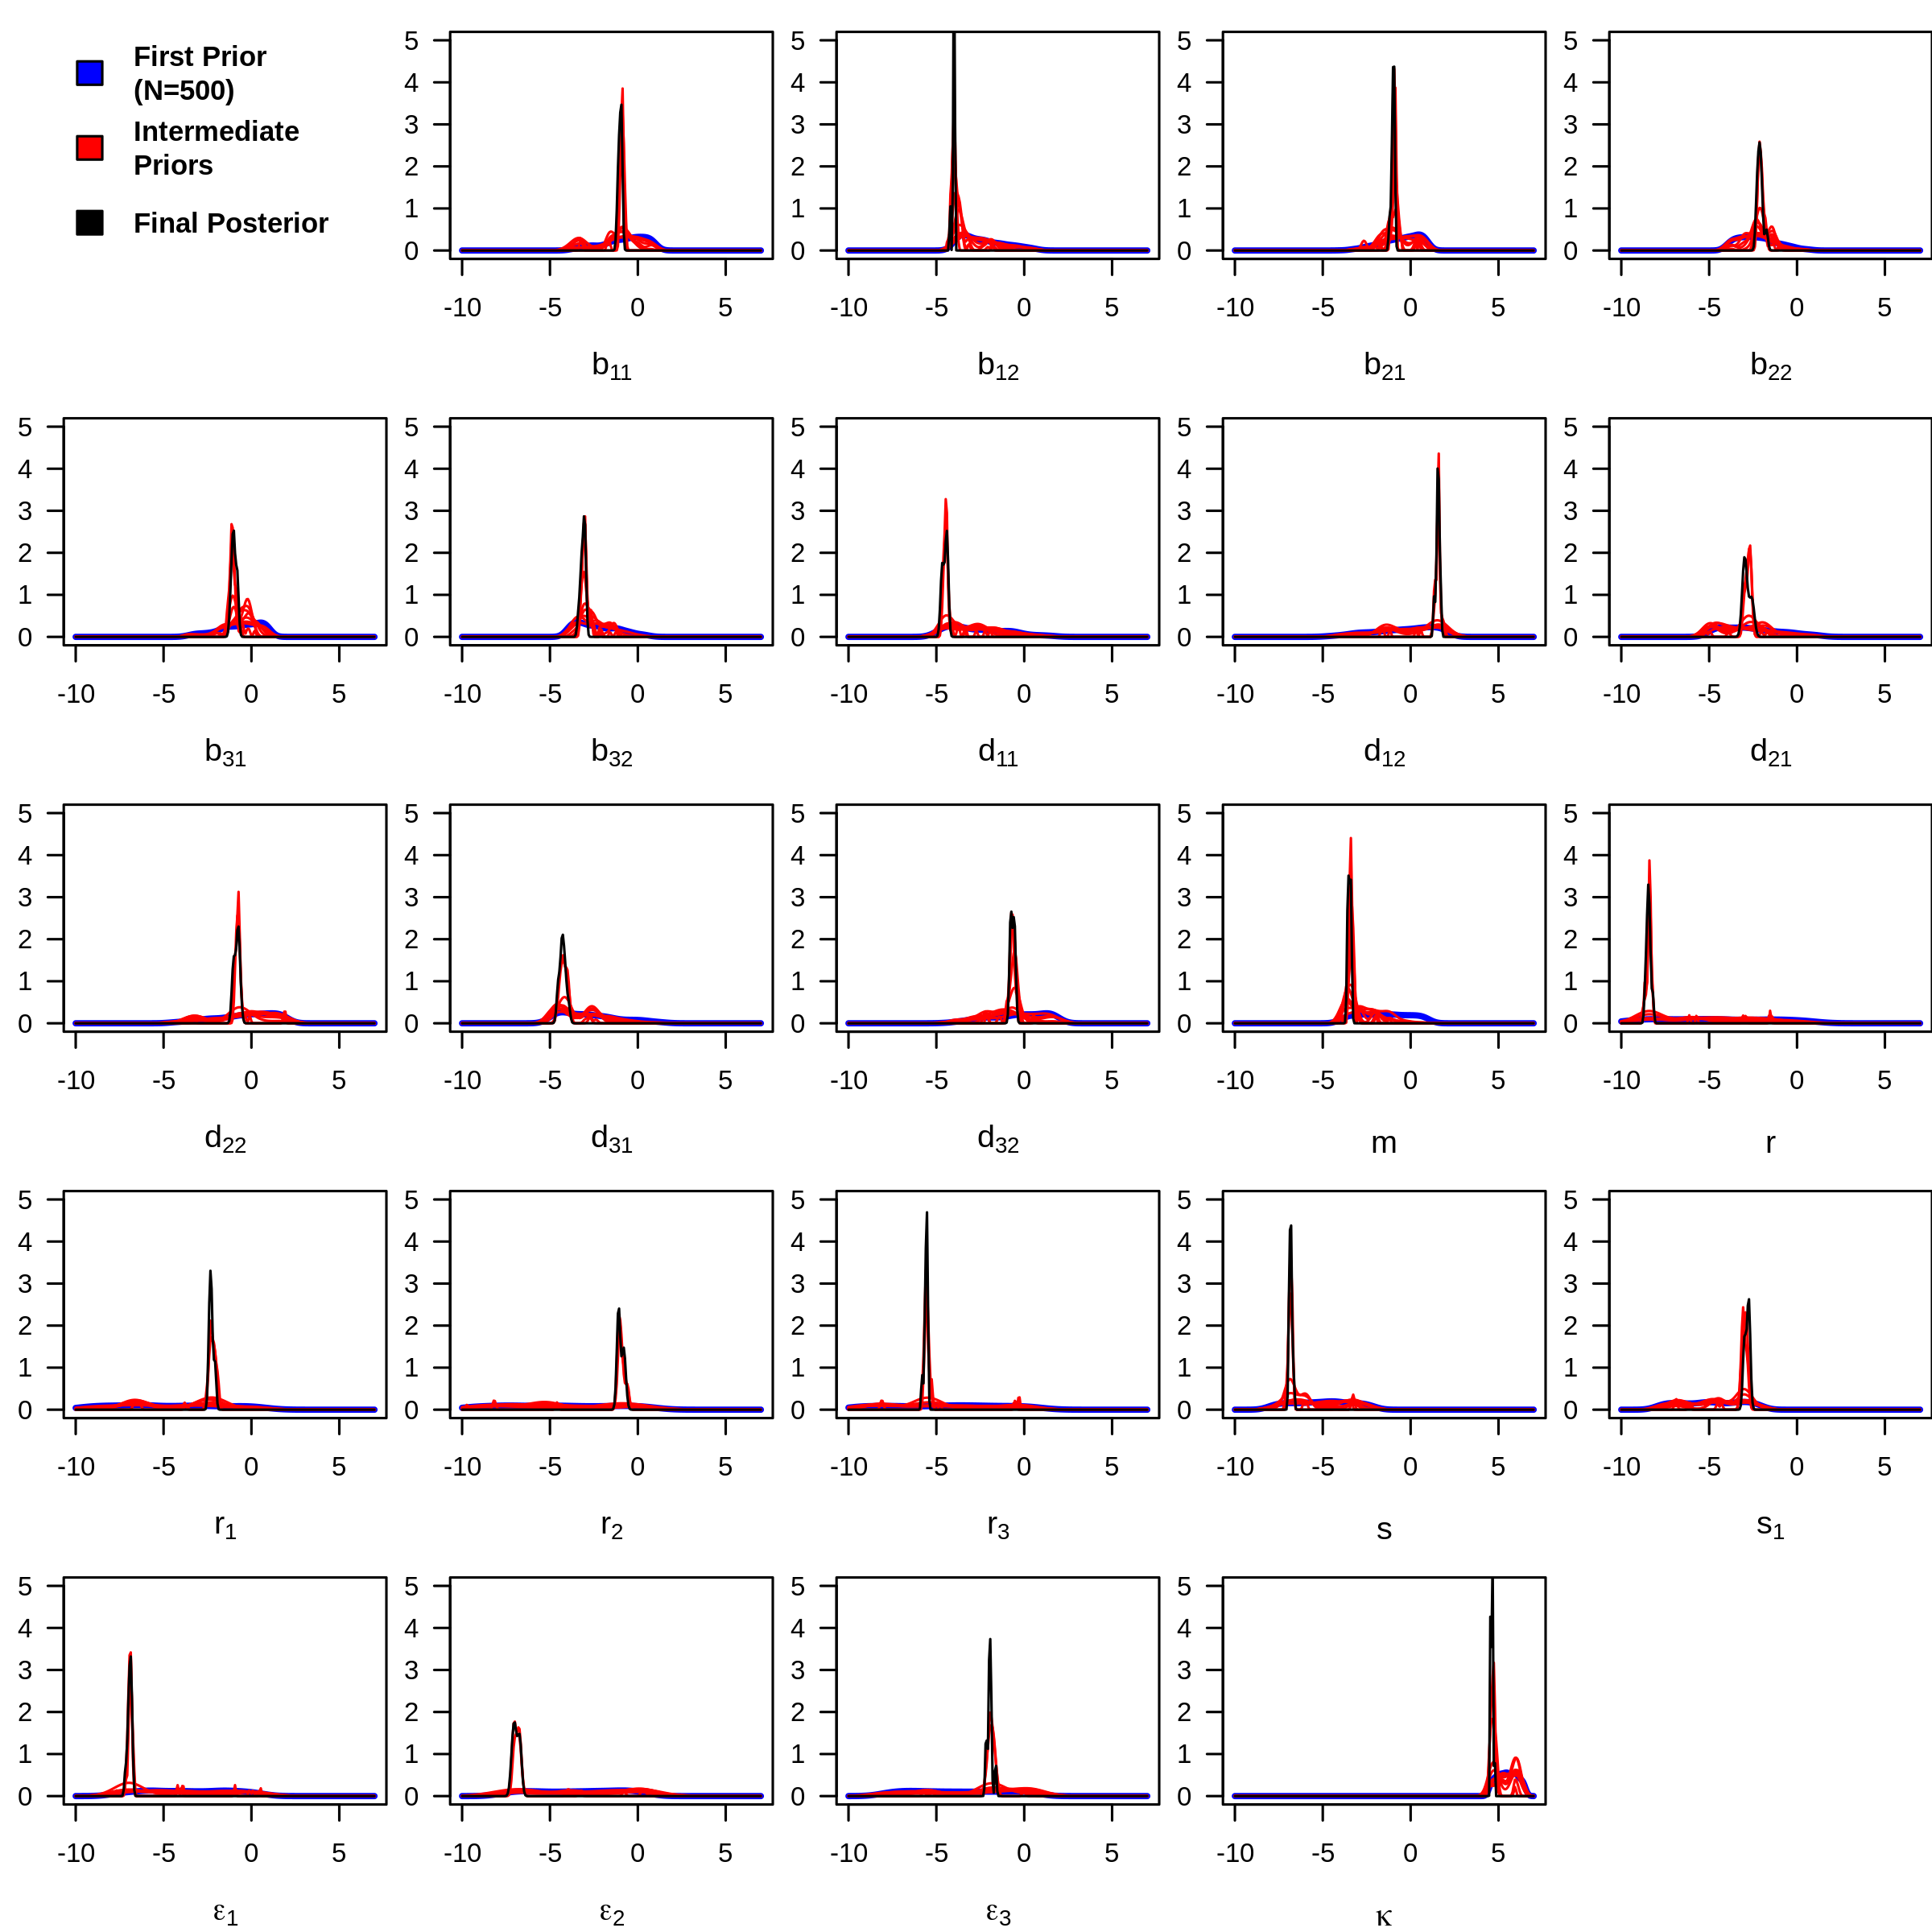

In [6]:
#All model parameters
n<-500
#par(mfrow=c(5,5), mar=c(4,0,1,0),font=2)
par(mfrow=c(5,5), mar=c(4,2,1,0),font=2)
plot(NULL ,xaxt='n',yaxt='n',bty='n', xlab="", ylab="",xlim=0:1, ylim=0:1)
plot_colors <- c("blue","red","black")
legend(x=-0.1,y=1.2,c(paste0("First Prior 
(N=",n,")"),"Intermediate 
Priors" ,"Final Posterior"),
        col=c("blue","red","black"),bty="n",cex=1.05,box.lwd = .8,fill=c("blue","red","black"),horiz=F)


for (k in 1:23) {
  plot(x, density_post[[n]][[1]][k, ], type="l", ylim=c(0,5),
       xlab=parameter_labels[k],ylab="", col="blue",cex.lab=1.2,lwd=2.5,las=1) 
  
    
  for (j in 2:10) {
    lines(x,density_post[[n]][[j]][k, ], yaxt= "n",col="red",lwd=1,pch=4,ann=FALSE,yaxt="n")
  }
    
     lines(x, density_post[[n]][[11]][k, ], col="black", lwd=1,ann=FALSE,yaxt="n")
   
}




# ABC post-processing analysis

Based on Proposed regression adjustment and Beaumont local linear regression

In [8]:


#### External scripts for the simulation model and ABC #####

#Script of function for computing event rates
source("Computing-rates-script.r")

# Script of function for updating exact SSA
source("Update-exactSSA-script.r")

# Script of function for updating tau-leaping
source("Update-tauleaping-script.r")

# Script of function experimental descriptors 
# (fish type, strain, fish size, fish sex and areas of the 4 body regions)
source("Descriptors-Data-script.r")

# Script of function for simulating parasites only a single fish over time and across body regions
source("Simulation-single-fish-script.r")

# Script of function for simulating parasites for a group fish over time and across body regions
#Corresponding to the empirical data
source("Simulation-Group-fish-script.r")

#Script of functions for Galton-Watson & GMM estimation of the B-D-C parameters
source("MLE_catastrophe-script.r")
source("GMM-1st2nd-Steps-script.r")
source("BDC-GW-GMM-estimator-script.r")

#Script for population projection until day 17 after fish death to aid with ABC fitting
source("Project-Parasite-script.r")

#Script for function used to compute the 17 summary statistics for ABC fitting:
#1.Log count across time (9)
#2.Wasserstein distance between the four body regions (4),
#3.Estimates of the B-D-C model parameters (3)
#4.Time before death (1)
source("summary-stats-ABC-script.r")


#Function for posterior adjustment using Weighted Ridge Regression

source("Post-Beaumount-LogLinear-script.R")
source("Post-Ridge-reg-adj-L2-script.R")

In [9]:
#To detect the number of processors or cores of your computer 
numCores<-min(16,detectCores())
numCores

[1] 4

# Importing empirical data and data on body areas

In [10]:
#Importing empirical data 
Combined_data <- read.csv(file="Parasite_Data.csv") 
#Importing data for area of the 8 body parts across 18 fish (measured in millimeters square)
Bodyparts_area<-read.csv(file="Area_Fish_bodyParts.csv")

In [11]:
#Experimental descriptors
Descriptors<- Experiment_descriptors(empirical_data=Combined_data)

fishSize <- Descriptors$fishSize #fish size
fishSex  <- Descriptors$fishSex #fish sex
Strain   <- Descriptors$Strain # parasite strain
Fish_stock<-Descriptors$Fish_stock #fish stock
numF    <-  Descriptors$numF # total fish for each parasite-fish group 
fishID  <-  Descriptors$fishID # fish IDs for each parasite-fish group 
pop_obs <-  Descriptors$pop_obs # observed parasite numbers for each parasite-fish group 
alive_obs<- Descriptors$alive_obs # observed surviva status for each parasite-fish group 
Area_normalized<- Body_area(Area_data=Bodyparts_area)#body areas

#Parasite-fish groups
parasite_fish<-c("Gt3-OS","Gt3-LA","Gt3-UA","Gt-OS","Gt-LA","Gt-UA","Gb-OS","Gb-LA","Gb-UA") 

# B-D-C parameter estimates for the parasite-fish groups based on observed data

In [12]:
#B-D-C parameter estimates for the parasite-fish groups based on observed data
BDC_estimates_obs<- GW_GMM_BDCestimator(X0=2,pop=pop_obs,alive=alive_obs,
                                        group=parasite_fish)$BDC_estimates
BDC_estimates_obs

[,1]       [,2]       [,3]        
 [1,] 20.7822916 20.7765959  0.000010000
 [2,]  3.9043373  3.7755263  0.000010000
 [3,]  0.8895400  0.5055642  0.009489619
 [4,]  1.8017937  1.6362905  0.000010000
 [5,]  5.3324106  5.2846054  0.000010000
 [6,]  0.7186602  0.5879474  0.294836121
 [7,]  4.7035677  4.4551256  0.000010000
 [8,]  0.7558293  0.3580435  0.002389751
 [9,]  0.3640324  0.2881294 17.775538263

In [13]:
#Function to store summary stats across all fish for ABC
Summary_stats<-function(pop,alive,BDC_estimates){
    parasite_fish<-c("Gt3-OS","Gt3-LA","Gt3-UA","Gt-OS","Gt-LA",
                     "Gt-UA","Gb-OS","Gb-LA","Gb-UA") 
    dimS <- 17 #length of summary statistics
    summaries=NULL
   for (pf in 1:length(parasite_fish)){
      summaries[[pf]] <- array(dim=c(numF[[pf]],dimS))
      for (k in 1:numF[[pf]]) {
          summaries[[pf]][k,] <- summary_compiler(pop_single=pop[[pf]][k,,], 
                                    alive_single=alive[[pf]][k,],group_number=pf,
                                    BDC_estimates=BDC_estimates)
                                  }
                             }
    return(summaries) #returns the 17 summary stats
   }

#Computing summary statistics for observed data across the parasite-fish groups
summaries_obs<-Summary_stats(pop=pop_obs,alive=alive_obs,BDC_estimates=BDC_estimates_obs)


In [14]:
#View ABC summary statistics for the observed data
summaries_obs[[1]]# for group 1 or Gt3-0S group

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
 [1,] 0.6931472 1.0986123 1.7917595 1.7917595 3.9889840 3.6635616 3.2188758
 [2,] 0.6931472 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [3,] 0.6931472 1.6094379 2.0794415 2.0794415 4.1271344 3.4657359 2.6390573
 [4,] 0.6931472 0.6931472 1.0986123 1.0986123 1.3862944 1.9459101 1.3862944
 [5,] 0.6931472 1.3862944 2.3025851 2.3025851 0.6931472 0.6931472 0.6931472
 [6,] 0.6931472 1.3862944 2.0794415 2.0794415 4.2046926 4.3438054 4.6151205
 [7,] 1.0986123 1.0986123 0.6931472 0.6931472 0.0000000 0.0000000 0.0000000
 [8,] 1.3862944 1.3862944 1.7917595 1.7917595 1.6094379 0.6931472 0.0000000
 [9,] 1.0986123 1.9459101 2.4849066 2.4849066 2.3978953 2.8903718 3.1780538
[10,] 1.6094379 1.9459101 2.3978953 2.3978953 4.1271344 2.8903718 0.6931472
[11,] 0.6931472 1.0986123 1.9459101 1.9459101 4.3944492 5.2417470 6.3856723
[12,] 0.6931472 0.6931472 1.3862944 1.3862944 2.1972246 1.3862944 1.3862944
[13,] 0.6931472 1.9459101 2.8332133 2.8332133 3.3672958 4.3820266 5.1817836
[14,] 0.6931472 0.6931472 2.0794415 2.0794415 2.7080502 1.3862944 1.6094379
      [,8]      [,9]      [,10]     [,11]     [,12] [,13]      [,14]    [,15]  
 [1,] 2.8332133 2.0794415 0.9960159 0.3984064 0     0.07141246 20.78229 20.7766
 [2,] 0.0000000 0.0000000 0.0000000 0.0000000 0     0.00000000 20.78229 20.7766
 [3,] 1.6094379 2.0794415 0.2490040 0.7470120 0     0.44552469 20.78229 20.7766
 [4,] 0.6931472 0.6305509 0.0000000 0.0000000 0     0.33200531 20.78229 20.7766
 [5,] 1.3862944 0.0000000 1.9920319 0.9960159 0     0.00000000 20.78229 20.7766
 [6,] 4.6443909 5.1914463 0.9960159 0.5217226 0     0.06683224 20.78229 20.7766
 [7,] 0.0000000 0.0000000 0.9960159 0.0000000 0     0.00000000 20.78229 20.7766
 [8,] 0.0000000 0.0000000 0.9960159 0.3320053 0     0.39840637 20.78229 20.7766
 [9,] 1.0986123 0.0000000 0.8300133 0.5583726 0     0.57044549 20.78229 20.7766
[10,] 0.6931472 0.6931472 0.1660027 0.2324037 0     0.36575011 20.78229 20.7766
[11,] 7.5320645 8.6792422 0.9960159 0.6640106 0     0.11620186 20.78229 20.7766
[12,] 1.3862944 2.3978953 1.9920319 1.3280212 0     0.45650730 20.78229 20.7766
[13,] 5.1179938 5.6983936 0.0000000 0.2490040 0     0.21343199 20.78229 20.7766
[14,] 2.3025851 1.0986123 0.0000000 0.5691520 0     0.64029596 20.78229 20.7766
      [,16] [,17]
 [1,] 1e-05 9    
 [2,] 1e-05 9    
 [3,] 1e-05 9    
 [4,] 1e-05 8    
 [5,] 1e-05 9    
 [6,] 1e-05 8    
 [7,] 1e-05 9    
 [8,] 1e-05 9    
 [9,] 1e-05 9    
[10,] 1e-05 9    
[11,] 1e-05 6    
[12,] 1e-05 9    
[13,] 1e-05 8    
[14,] 1e-05 9

# Importing final posterior at different sample sizes of initial prior distn

N=500.

In [125]:
#Importing final posterior at different sample sizes of initial prior distn
Final_posterior<-NULL
draws<- c(500)
for (n in draws){
  Final_posterior[[n]]<- read.csv(paste0("PosteriorFinal_", n, ".csv"))
  Final_posterior[[n]]<-Final_posterior[[n]][,-1]
  #print(paste("draws=",n))
  #print(Final_posterior[[n]])
}

#Estimating the 95% Credible interval for the unadjusted posterior
ci_eti<- NULL;Posterior_estimates_unadj<- NULL

for(n in draws){
  #computing credible intervals (ETI)
  post_data<-   Final_posterior[[n]]
  ci_eti[[n]]<- ci(as.data.frame(post_data), ci = 0.95,method = "ETI") 
  ci_eti[[n]]<- exp(ci_eti[[n]][,3:4])
   # estimating the  posterior  mean estimate
  Posterior_estimates_unadj[[n]]<- apply(exp(Final_posterior[[n]]),2,mean)
    }

Posterior_est_unadj_data<- data.frame(Posterior_estimate_unadj=Posterior_estimates_unadj[[500]],
                                     Cred_Int_lower95_unadj= ci_eti[[500]][,1],
                                     Cred_Int_upper95_unadj= ci_eti[[500]][,2])

#Print unadjusted posterior estimates with 95% credible intervals
Posterior_est_unadj_data

Posterior_estimate_unadj Cred_Int_lower95_unadj Cred_Int_upper95_unadj
V1  3.664044e-01             3.133116e-01           4.092558e-01          
V2  1.811519e-02             1.526969e-02           1.913379e-02          
V3  3.682176e-01             3.123895e-01           3.987035e-01          
V4  1.235632e-01             1.010003e-01           1.658747e-01          
V5  3.777583e-01             3.097097e-01           4.515250e-01          
V6  4.439107e-02             3.531119e-02           5.022999e-02          
V7  1.102459e-02             8.906418e-03           1.274585e-02          
V8  4.729410e+00             3.852081e+00           5.480785e+00          
V9  5.942112e-02             4.649222e-02           8.182961e-02          
V10 4.346025e-01             3.474176e-01           5.246951e-01          
V11 1.409390e-02             1.071100e-02           1.860917e-02          
V12 5.179375e-01             4.467116e-01           6.026094e-01          
V13 3.073260e-02             2.757985e-02           3.382959e-02          
V14 2.155524e-04             1.793363e-04           2.632773e-04          
V15 1.034074e-01             8.804277e-02           1.279144e-01          
V16 3.823572e-01             3.240389e-01           4.859122e-01          
V17 3.744237e-03             3.085581e-03           4.112230e-03          
V18 1.093328e-03             9.946895e-04           1.259067e-03          
V19 5.878720e-02             4.803435e-02           6.845711e-02          
V20 9.848305e-04             7.993255e-04           1.118368e-03          
V21 1.002344e-03             7.686147e-04           1.258251e-03          
V22 1.426919e-01             1.135900e-01           1.856702e-01          
V23 1.035974e+02             9.350342e+01           1.163865e+02

  **Function for computing weighted distance between simulated and observed summary statistics (ABC)**

In [28]:
w_distance <- function(S1, S2, weight)  {
  n<- dim(S1)[1]
  Squared_diff_mat<- (S1-S2)^2 #squared difference between matrix S1 & S2
  #Multiplying vector to weights to each rows of  Squared_diff_mat
  Weighted_sq_diff<- lapply(1:dim(S1)[1],
              function(k) weight*Squared_diff_mat[k, ])
  WSS<- do.call("sum",Weighted_sq_diff)#total weighted distances (WSS)
  return(sqrt(WSS/n))#return weighted sum of square distance 
}

In [26]:
#Observed summary statistics across all observed fish
SummaryStats_obs_combined<- do.call("rbind", summaries_obs)

# Initial simulation inputs for A (parasite numbers) and B (immune status)

In [27]:
#Initial simulation inputs for A (parasite numbers) and  B (immune status)
A0 <- matrix(0, 4, 2)  
A0[1, 1] <- 2   #Intial parasites at the tail
B0 <- rep(1, 4)  #initial immune response at 4 body regions (no response)

#Transition matrix
J<- matrix(c(0,    1,    0,     0, 
             1/2,   0,    1/2,   0,
             0,    1/2,    0,   1/2,
             0,     0,     1,    0), 4, 4, byrow=TRUE)
        

# Function for simulating group of fish from posterior estimates corresponding to empirical data.

https://en.wikipedia.org/wiki/Kernel_(statistics)

In [29]:
na.inf.zero<- function(x){
    x[is.na(x)|is.finite(x)==FALSE]<- 0
    return(x)
}


# Function of ABC posterior adjustment using a modified Local Linear Regression- i.e Weighted Ridge regression (based on Gaussian kernel).



http://www.wseas.us/e-library/conferences/2012/Porto/MAMECTIS/MAMECTIS-20.pdf



https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/24/lecture-24--25.pdf


https://arxiv.org/pdf/1509.09169.pdf

**Adjustment of Posterior at N=500 based on Proposed regression adjustment**

In [129]:
Reg_adjust_L2<- function(i) Post_Ridge_reg_adj(post_distn=Final_posterior[[draws[i]]],
                                    summary_obs= SummaryStats_obs_combined)

Output_adj_L2<- mclapply(seq_along(draws),Reg_adjust_L2,mc.cores=numCores)

In [132]:
#Adjustment of Posterior at N=500 based on Proposed regression adjustment
#Output_adj_L2[[1]]$Posterior_mean_output


print(paste("Proposed adjusted posterior estimates at N=",draws[1]))
Output_adj_L2[[1]]$Posterior_mean_output[,1]

print(paste("ABC posterior estimates at N=",draws[1]))
Output_adj_L2[[1]]$Posterior_mean_output[,2]


[1] "Proposed adjusted posterior estimates at N= 500"


[1] 3.651270e-01 5.313427e-02 3.632767e-01 1.248821e-01 5.912598e-01
 [6] 4.467780e-02 1.081110e-02 4.218745e+00 7.984001e-02 4.450390e-01
[11] 1.429041e-02 5.211849e-01 2.309237e-02 2.158640e-04 1.028970e-01
[16] 4.009032e-01 3.691061e-03 1.126410e-03 5.905062e-02 1.223991e-03
[21] 9.616526e-04 2.778369e-01 1.045463e+02

[1] "ABC posterior estimates at N= 500"


[1] 3.664044e-01 1.811519e-02 3.682176e-01 1.235632e-01 3.777583e-01
 [6] 4.439107e-02 1.102459e-02 4.729410e+00 5.942112e-02 4.346025e-01
[11] 1.409390e-02 5.179375e-01 3.073260e-02 2.155524e-04 1.034074e-01
[16] 3.823572e-01 3.744237e-03 1.093328e-03 5.878720e-02 9.848305e-04
[21] 1.002344e-03 1.426919e-01 1.035974e+02

In [50]:
#Saving output
for(i in seq_along(draws)) {
    write.csv(Output_adj_L2[[i]]$Posterior_mean_output,
                        paste0("Posterior_mean_adjustment_L2_",draws[i],".csv"))

    write.csv(Output_adj_L2[[i]]$Adjusted_posterior_dist,
                        paste0("Posterior_adjusted_distn_L2_",draws[i],".csv"))

               }

# Correlation matrix plot showing significantly high multicollinearity of predictors (Design matrix)


This suggests a perfect multicollinearity between the 17 predictors (i.e, 17 distinct summary statistics per host). This explains why the Regression adjustment based on Beaumount et al.'s local linear cannot be fitted due to matrix $X^{\top}W X$ is not invertible.

**Visualize correlation matrix using correlogram**

In [133]:
library("corrplot")

i=1
M<-cor(Output_adj_L2[[i]]$X_Design_matrix)
head(round(M,2))


# mat : is a matrix of data
# ... : further arguments to pass to the native R cor.test function
cor.mtest <- function(mat, ...) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat<- matrix(NA, n, n)
    diag(p.mat) <- 0
    for (i in 1:(n - 1)) {
        for (j in (i + 1):n) {
            tmp <- cor.test(mat[, i], mat[, j], ...)
            p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
        }
    }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  p.mat
}
# matrix of the p-value of the correlation
i=1
p.mat <- cor.mtest(Output_adj_L2[[i]]$X_Design_matrix)
head(p.mat[, 1:5])



[,1] [,2] [,3] [,4] [,5] [,6] [,7]  [,8]  [,9]  [,10] [,11] [,12] [,13]
[1,] 1.00 0.84 0.73 0.46 0.19 0.02 -0.14 -0.19 -0.24 0.12  -0.44  0.43 0.37 
[2,] 0.84 1.00 0.97 0.80 0.51 0.32  0.16  0.10  0.04 0.51  -0.47  0.44 0.37 
[3,] 0.73 0.97 1.00 0.87 0.66 0.50  0.35  0.29  0.23 0.50  -0.48  0.26 0.30 
[4,] 0.46 0.80 0.87 1.00 0.90 0.78  0.67  0.62  0.58 0.67  -0.31  0.22 0.39 
[5,] 0.19 0.51 0.66 0.90 1.00 0.97  0.92  0.89  0.87 0.47  -0.35 -0.06 0.39 
[6,] 0.02 0.32 0.50 0.78 0.97 1.00  0.98  0.97  0.96 0.38  -0.32 -0.24 0.33 
     [,14] [,15] [,16] [,17]
[1,] -0.49 -0.03 -0.04  0.37
[2,] -0.27  0.21  0.01  0.22
[3,] -0.11  0.25 -0.02  0.05
[4,] -0.05  0.43 -0.01  0.04
[5,]  0.05  0.42 -0.05 -0.09
[6,]  0.08  0.30 -0.05 -0.20

[,1]        [,2]         [,3]         [,4]         [,5]        
[1,] 0.000000000 2.334986e-03 1.601742e-02 0.1835075699 5.972419e-01
[2,] 0.002334986 0.000000e+00 5.101275e-06 0.0057344121 1.294079e-01
[3,] 0.016017420 5.101275e-06 0.000000e+00 0.0010771480 3.919822e-02
[4,] 0.183507570 5.734412e-03 1.077148e-03 0.0000000000 4.509072e-04
[5,] 0.597241948 1.294079e-01 3.919822e-02 0.0004509072 0.000000e+00
[6,] 0.966014553 3.621295e-01 1.403805e-01 0.0080856497 3.658168e-06

# **Visualize correlation matrix using correlogram**

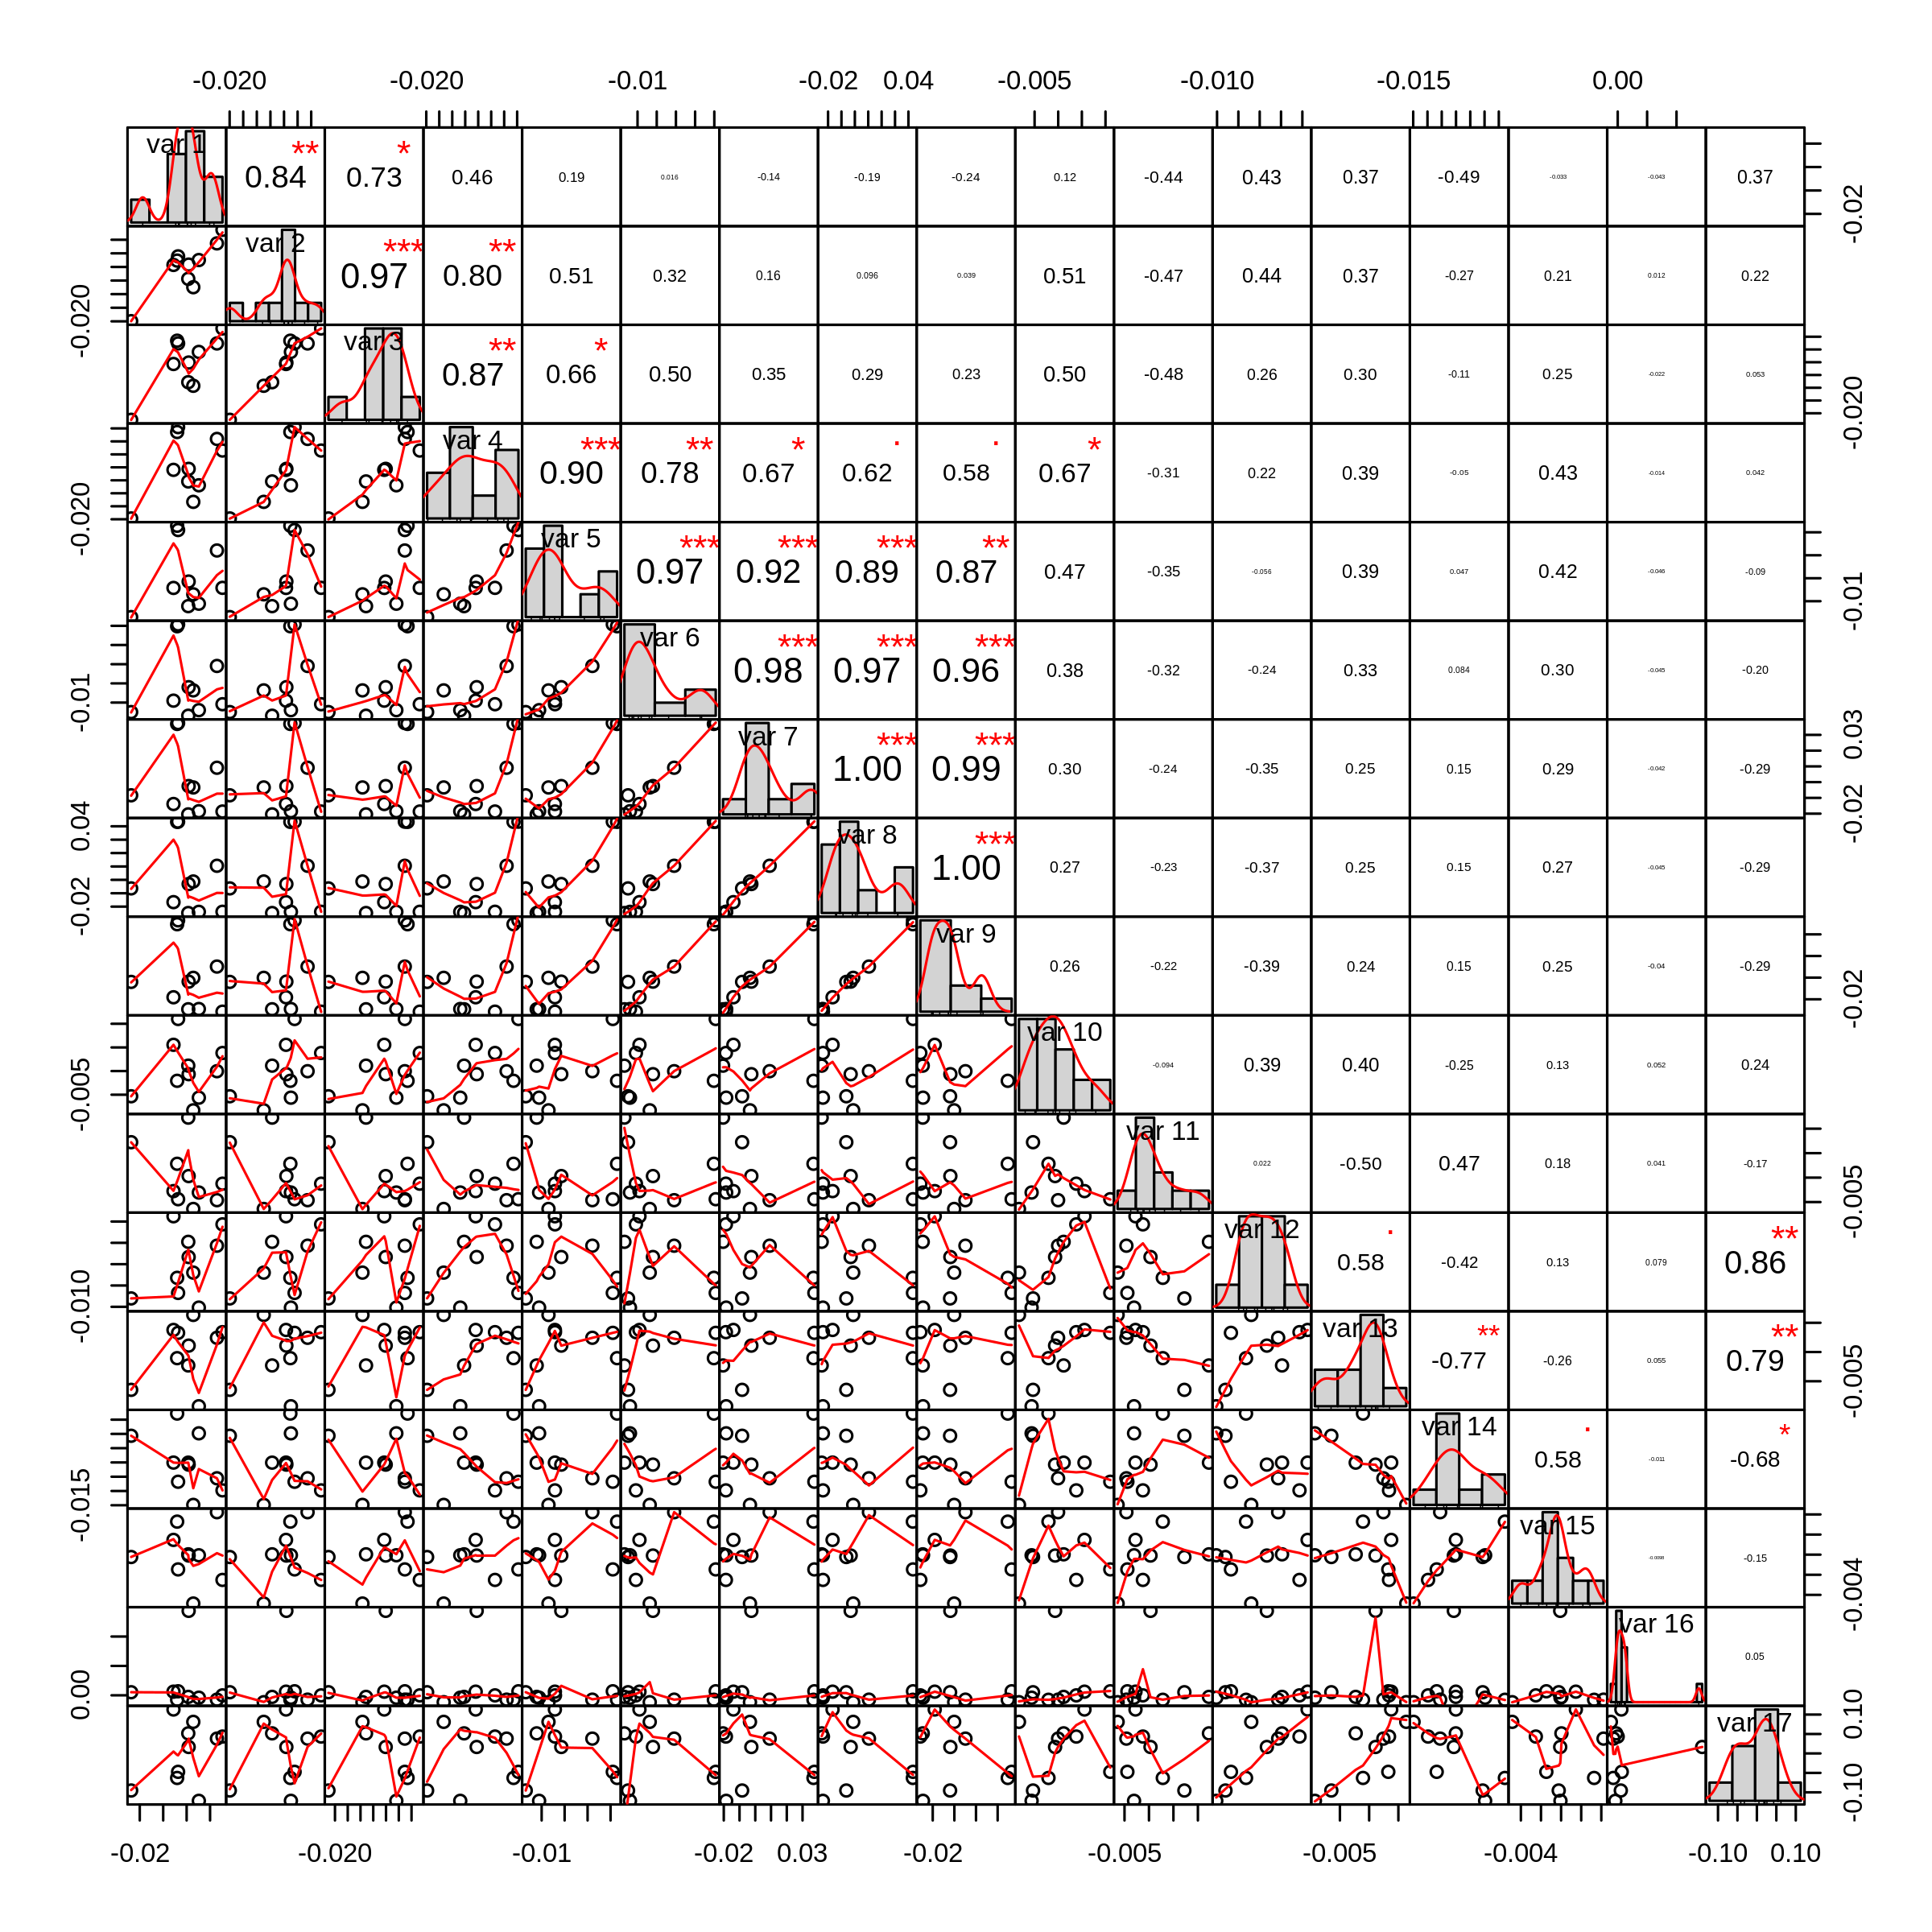

In [137]:
chart.Correlation(Output_adj_L2[[1]]$X_Design_matrix, histogram=TRUE, pch=19)

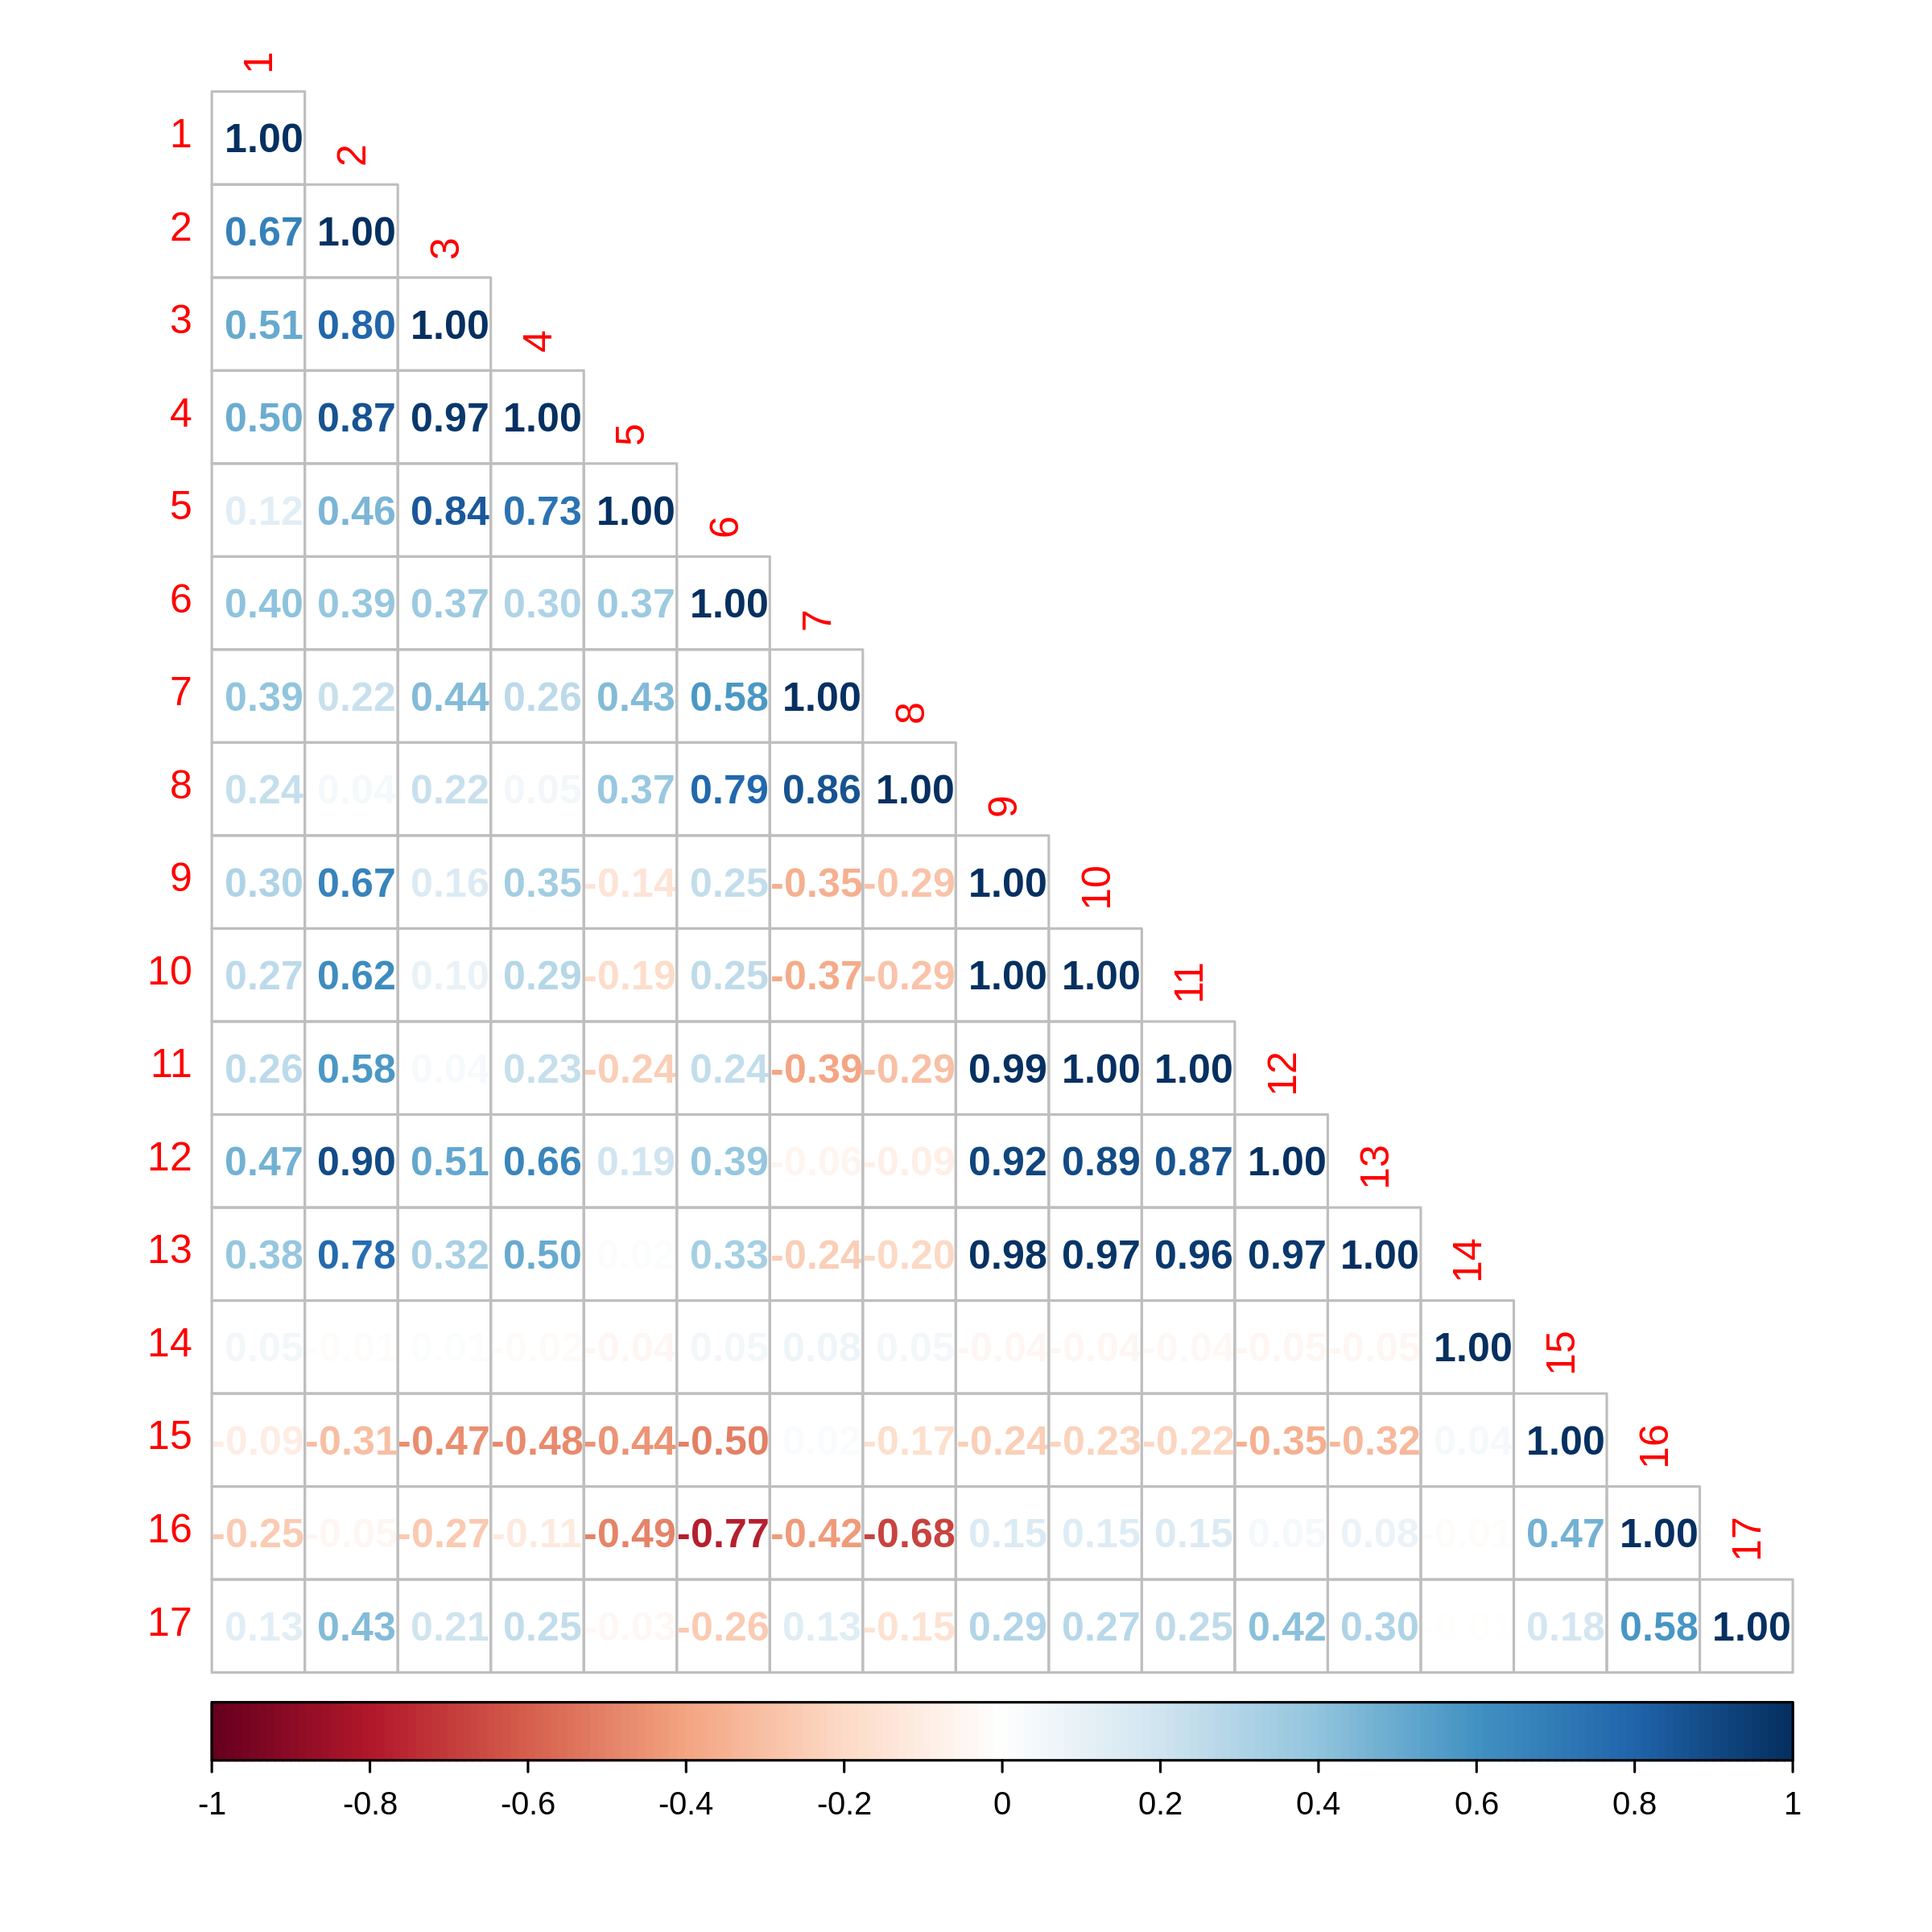

In [134]:
corrplot(M, method="number",type="lower", order="hclust")

**Adjustment of Posterior at N=500 based on Beaumont's local-linear regression adjustment**

NB: $X^{\top}W X$ is not invertible for Beaumont's local-linear regression adjustment

In [138]:
#Adjustment of Posterior at N=500 based on Proposed regression adjustment
Reg_adjust_Beaumont<- function(i) Post_Beaumont_reg_adj(post_distn=Final_posterior[[draws[i]]],
                                    summary_obs= SummaryStats_obs_combined)

Output_adj_Beaumont<- mclapply(seq_along(draws),Reg_adjust_Beaumont,mc.cores=numCores)

ERROR: Error in solve.default(t(X) %*% W %*% X): system is computationally singular: reciprocal condition number = 9.06506e-20


# Further analysis/visualisation

In [141]:
#Importing final posterior at different sample sizes of initial prior distn
Adjusted_posterior<-NULL
draws<- c(500)
for (n in draws){
  Adjusted_posterior[[n]]<- Output_adj_L2[[1]]$Adjusted_posterior_dist
}

#Estimating the 95% Credible interval for the unadjusted posterior
ci_eti_adj<- NULL;Posterior_estimates_adj<- NULL

  #computing credible intervals (ETI)
  post_data<-  Adjusted_posterior[[n]]
  ci_eti_adj[[n]]<- ci(as.data.frame(post_data), ci = 0.95,method = "ETI") 
  ci_eti_adj[[n]]<- exp(ci_eti_adj[[n]][,3:4])
   # estimating the  posterior  mean estimate
  Posterior_estimates_adj[[n]]<- Output_adj_L2[[1]]$Posterior_mean_output[,1]
    

Posterior_est_adj_data<- data.frame(Posterior_estimate_adj=Posterior_estimates_adj[[500]],
                                     Cred_Int_lower95_adj= ci_eti_adj[[500]][,1],
                                     Cred_Int_upper95_adj= ci_eti_adj[[500]][,2])

#Print unadjusted posterior estimates with 95% credible intervals
Combined_posterior_adj_unadj<- cbind(Posterior_est_adj_data,Posterior_est_unadj_data)
Combined_posterior_adj_unadj

#Save output
write.csv(Combined_posterior_adj_unadj,"Post_Regression_output.csv")

Posterior_estimate_adj Cred_Int_lower95_adj Cred_Int_upper95_adj
V1  3.651270e-01           3.119936e-01         4.070946e-01        
V2  5.313427e-02           4.074003e-02         5.544072e-02        
V3  3.632767e-01           3.121010e-01         3.983173e-01        
V4  1.248821e-01           1.011357e-01         1.661017e-01        
V5  5.912598e-01           5.274774e-01         7.080126e-01        
V6  4.467780e-02           3.529470e-02         5.020353e-02        
V7  1.081110e-02           8.893770e-03         1.272384e-02        
V8  4.218745e+00           3.474935e+00         4.816930e+00        
V9  7.984001e-02           6.671476e-02         1.133474e-01        
V10 4.450390e-01           3.465651e-01         5.260394e-01        
V11 1.429041e-02           1.071985e-02         1.862146e-02        
V12 5.211849e-01           4.471090e-01         6.031482e-01        
V13 2.309237e-02           2.105598e-02         2.423107e-02        
V14 2.158640e-04           1.774566e-04         2.598316e-04        
V15 1.028970e-01           8.804697e-02         1.279065e-01        
V16 4.009032e-01           3.504955e-01         5.210640e-01        
V17 3.691061e-03           3.088494e-03         4.115238e-03        
V18 1.126410e-03           1.039375e-03         1.257291e-03        
V19 5.905062e-02           4.806403e-02         6.849388e-02        
V20 1.223991e-03           1.009427e-03         1.404088e-03        
V21 9.616526e-04           7.685273e-04         1.257715e-03        
V22 2.778369e-01           2.417448e-01         3.569201e-01        
V23 1.045463e+02           9.343877e+01         1.162911e+02        
    Posterior_estimate_unadj Cred_Int_lower95_unadj Cred_Int_upper95_unadj
V1  3.664044e-01             3.133116e-01           4.092558e-01          
V2  1.811519e-02             1.526969e-02           1.913379e-02          
V3  3.682176e-01             3.123895e-01           3.987035e-01          
V4  1.235632e-01             1.010003e-01           1.658747e-01          
V5  3.777583e-01             3.097097e-01           4.515250e-01          
V6  4.439107e-02             3.531119e-02           5.022999e-02          
V7  1.102459e-02             8.906418e-03           1.274585e-02          
V8  4.729410e+00             3.852081e+00           5.480785e+00          
V9  5.942112e-02             4.649222e-02           8.182961e-02          
V10 4.346025e-01             3.474176e-01           5.246951e-01          
V11 1.409390e-02             1.071100e-02           1.860917e-02          
V12 5.179375e-01             4.467116e-01           6.026094e-01          
V13 3.073260e-02             2.757985e-02           3.382959e-02          
V14 2.155524e-04             1.793363e-04           2.632773e-04          
V15 1.034074e-01             8.804277e-02           1.279144e-01          
V16 3.823572e-01             3.240389e-01           4.859122e-01          
V17 3.744237e-03             3.085581e-03           4.112230e-03          
V18 1.093328e-03             9.946895e-04           1.259067e-03          
V19 5.878720e-02             4.803435e-02           6.845711e-02          
V20 9.848305e-04             7.993255e-04           1.118368e-03          
V21 1.002344e-03             7.686147e-04           1.258251e-03          
V22 1.426919e-01             1.135900e-01           1.856702e-01          
V23 1.035974e+02             9.350342e+01           1.163865e+02

**ABC fitting with SMC and SIS at N=500 (Computational time)**

In [83]:
time_CPU<- NULL
for(n in draws) {
    time_CPU[[n]]<- read.csv(file=paste0("CPUtime_",n,".csv"))
    time_CPU[[n]]<- time_CPU[[n]][,-1]
    }

#Computational times
 for(i in seq_along(draws))  print(paste("CPU time at N=", draws[i],"",":",time_CPU[[draws[i]]]/10,"secs"))

 for(i in seq_along(draws))  print(paste("CPU time at N=", draws[i],"",":",time_CPU[[draws[i]]]/864000,"days"))

[1] "CPU time at N= 500  : 46485.9864 secs"
[1] "CPU time at N= 500  : 0.53803225 days"


In [85]:
#Converting from seconds to days
  library(lubridate)
 for(i in seq_along(draws))  print(paste("CPU time at N=", draws[i],"",":",seconds_to_period(time_CPU[[draws[i]]]/10)))

[1] "CPU time at N= 500  : 12H 54M 45.9864000000016S"


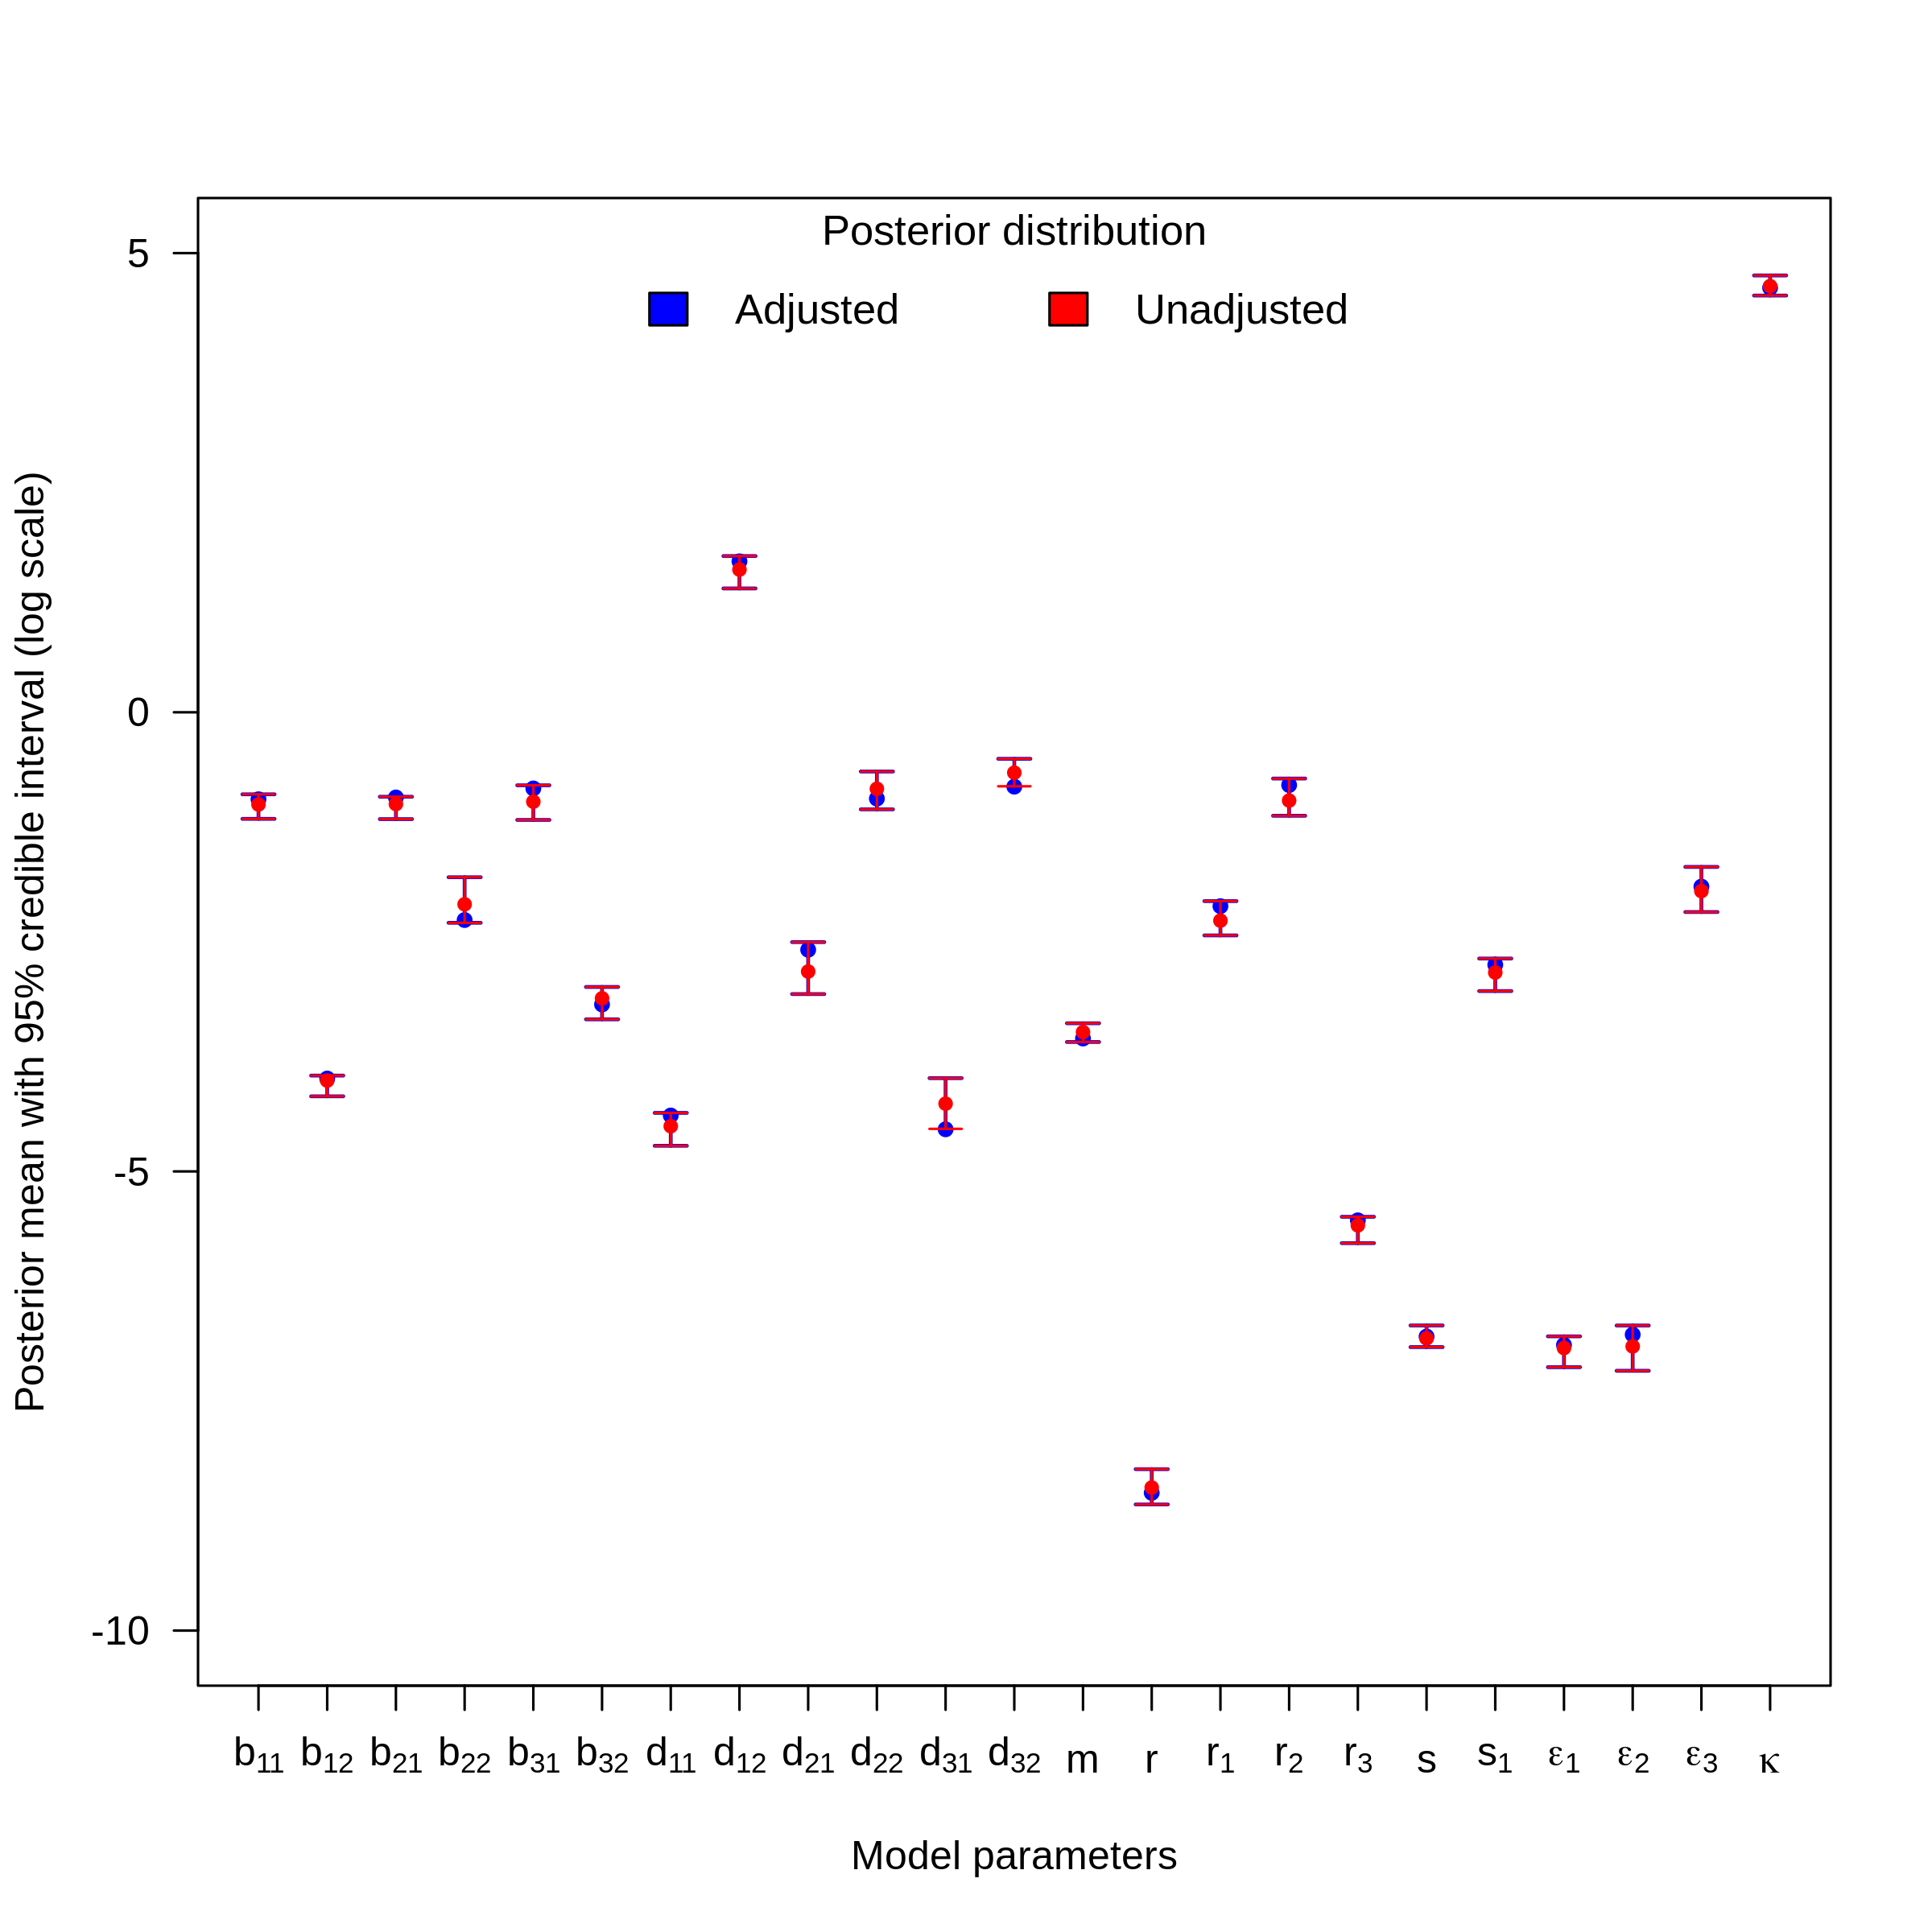

In [101]:
options(warn=-1)

require(plotrix)

#Adjusted posterior
x <- 1:23
F <- log(Combined_posterior_adj_unadj[,1])
L <-  log(Combined_posterior_adj_unadj[,2])
U <-  log(Combined_posterior_adj_unadj[,3])
plotCI(x, F, ui=U, li=L,xaxt="n",xlab="Model parameters",
       ylab="Posterior mean with 95% credible interval (log scale)",
       col="blue",lwd=1.5,ylim=c(-10,5),xaxt="n",pch=20
      ,las=1)

 axis(1, at=1:23, labels=parameter_labels)
legend(x=6,y=5.8,c("Adjusted","Unadjusted"),
        col=c("blue","red"),bty="n",cex=1.05,box.lwd = .8,fill=c("blue","red"),horiz=F,
      title="Posterior distribution")


#Unadjusted posterior
x <- 1:23
F <- log(Combined_posterior_adj_unadj[,4])
L <-  log(Combined_posterior_adj_unadj[,5])
U <-  log(Combined_posterior_adj_unadj[,6])
plotCI(x, F, ui=U, li=L,col="red", add=TRUE,lwd=1,pch=20)



# Density plot of undajusted and adjusted posterior distribution at N=500

In [142]:
#Estimating the kernel density of the adjusted posterior

density_post_adjusted<- array(dim=c(number_of_parameters, 256))

for(k in 1:number_of_parameters){
density_post_adjusted[k, ]<- density(Output_adj_L2[[1]]$Adjusted_posterior_dist[ ,k], from=-10, to=7, n=256)$y
}



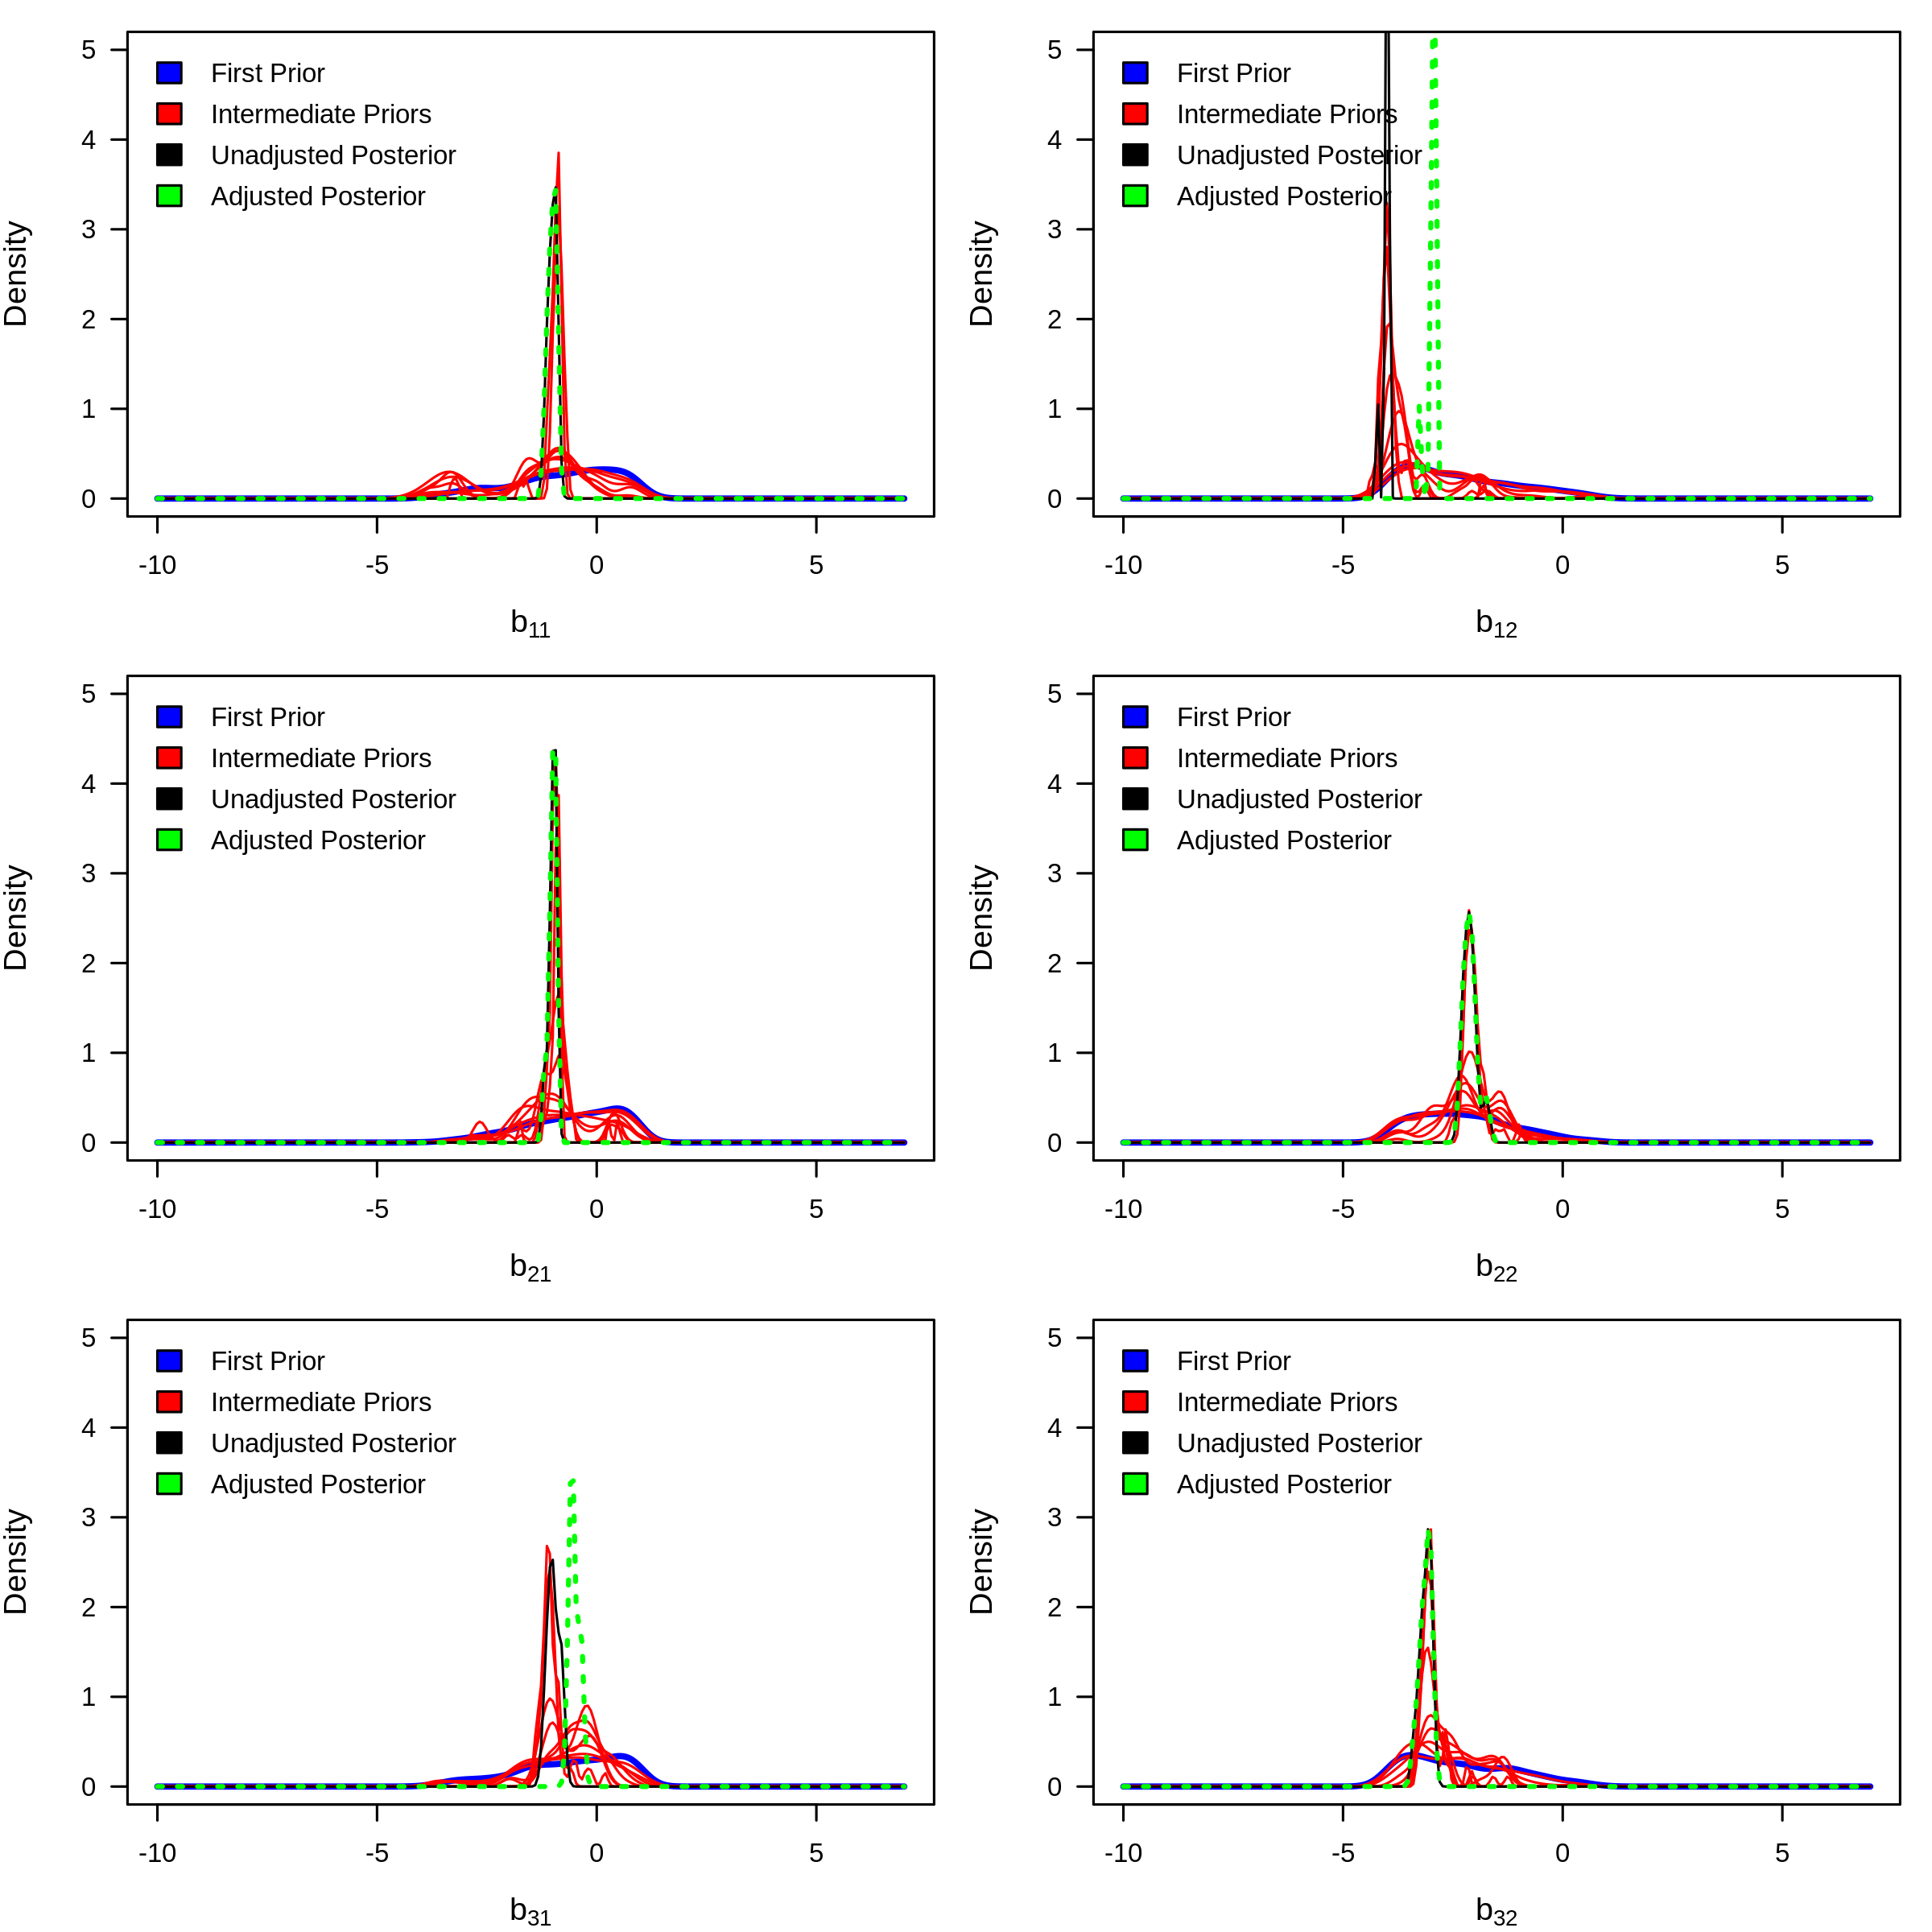

In [143]:
par(mfrow=c(3,2),mar=c(4,4,1,1))
n=500
x <- seq(from = -10, to = 7, length.out = 256)#range of prior distribution

for (k in 1:6) {
  plot(x, density_post[[n]][[1]][k, ], type="l", ylim=c(0,5),
       xlab=parameter_labels[k],ylab="Density", col="blue",cex.lab=1.2,lwd=2.5,las=1) 
  
    
  for (j in 2:10) {
    lines(x,density_post[[n]][[j]][k, ], yaxt= "n",col="red",lwd=1,pch=4,ann=FALSE,yaxt="n")
  }
    
     lines(x, density_post[[n]][[11]][k, ], col="black", lwd=1)
     lines(x,density_post_adjusted[k, ], col="green",lty=3,lwd=2)
    legend("topleft",c("First Prior","Intermediate Priors" ,"Unadjusted Posterior","Adjusted Posterior"),
         col=c("blue","red","black","green"),bty="n",cex=1,box.lwd = 2,fill=c("blue","red","black","green"))
    }
   

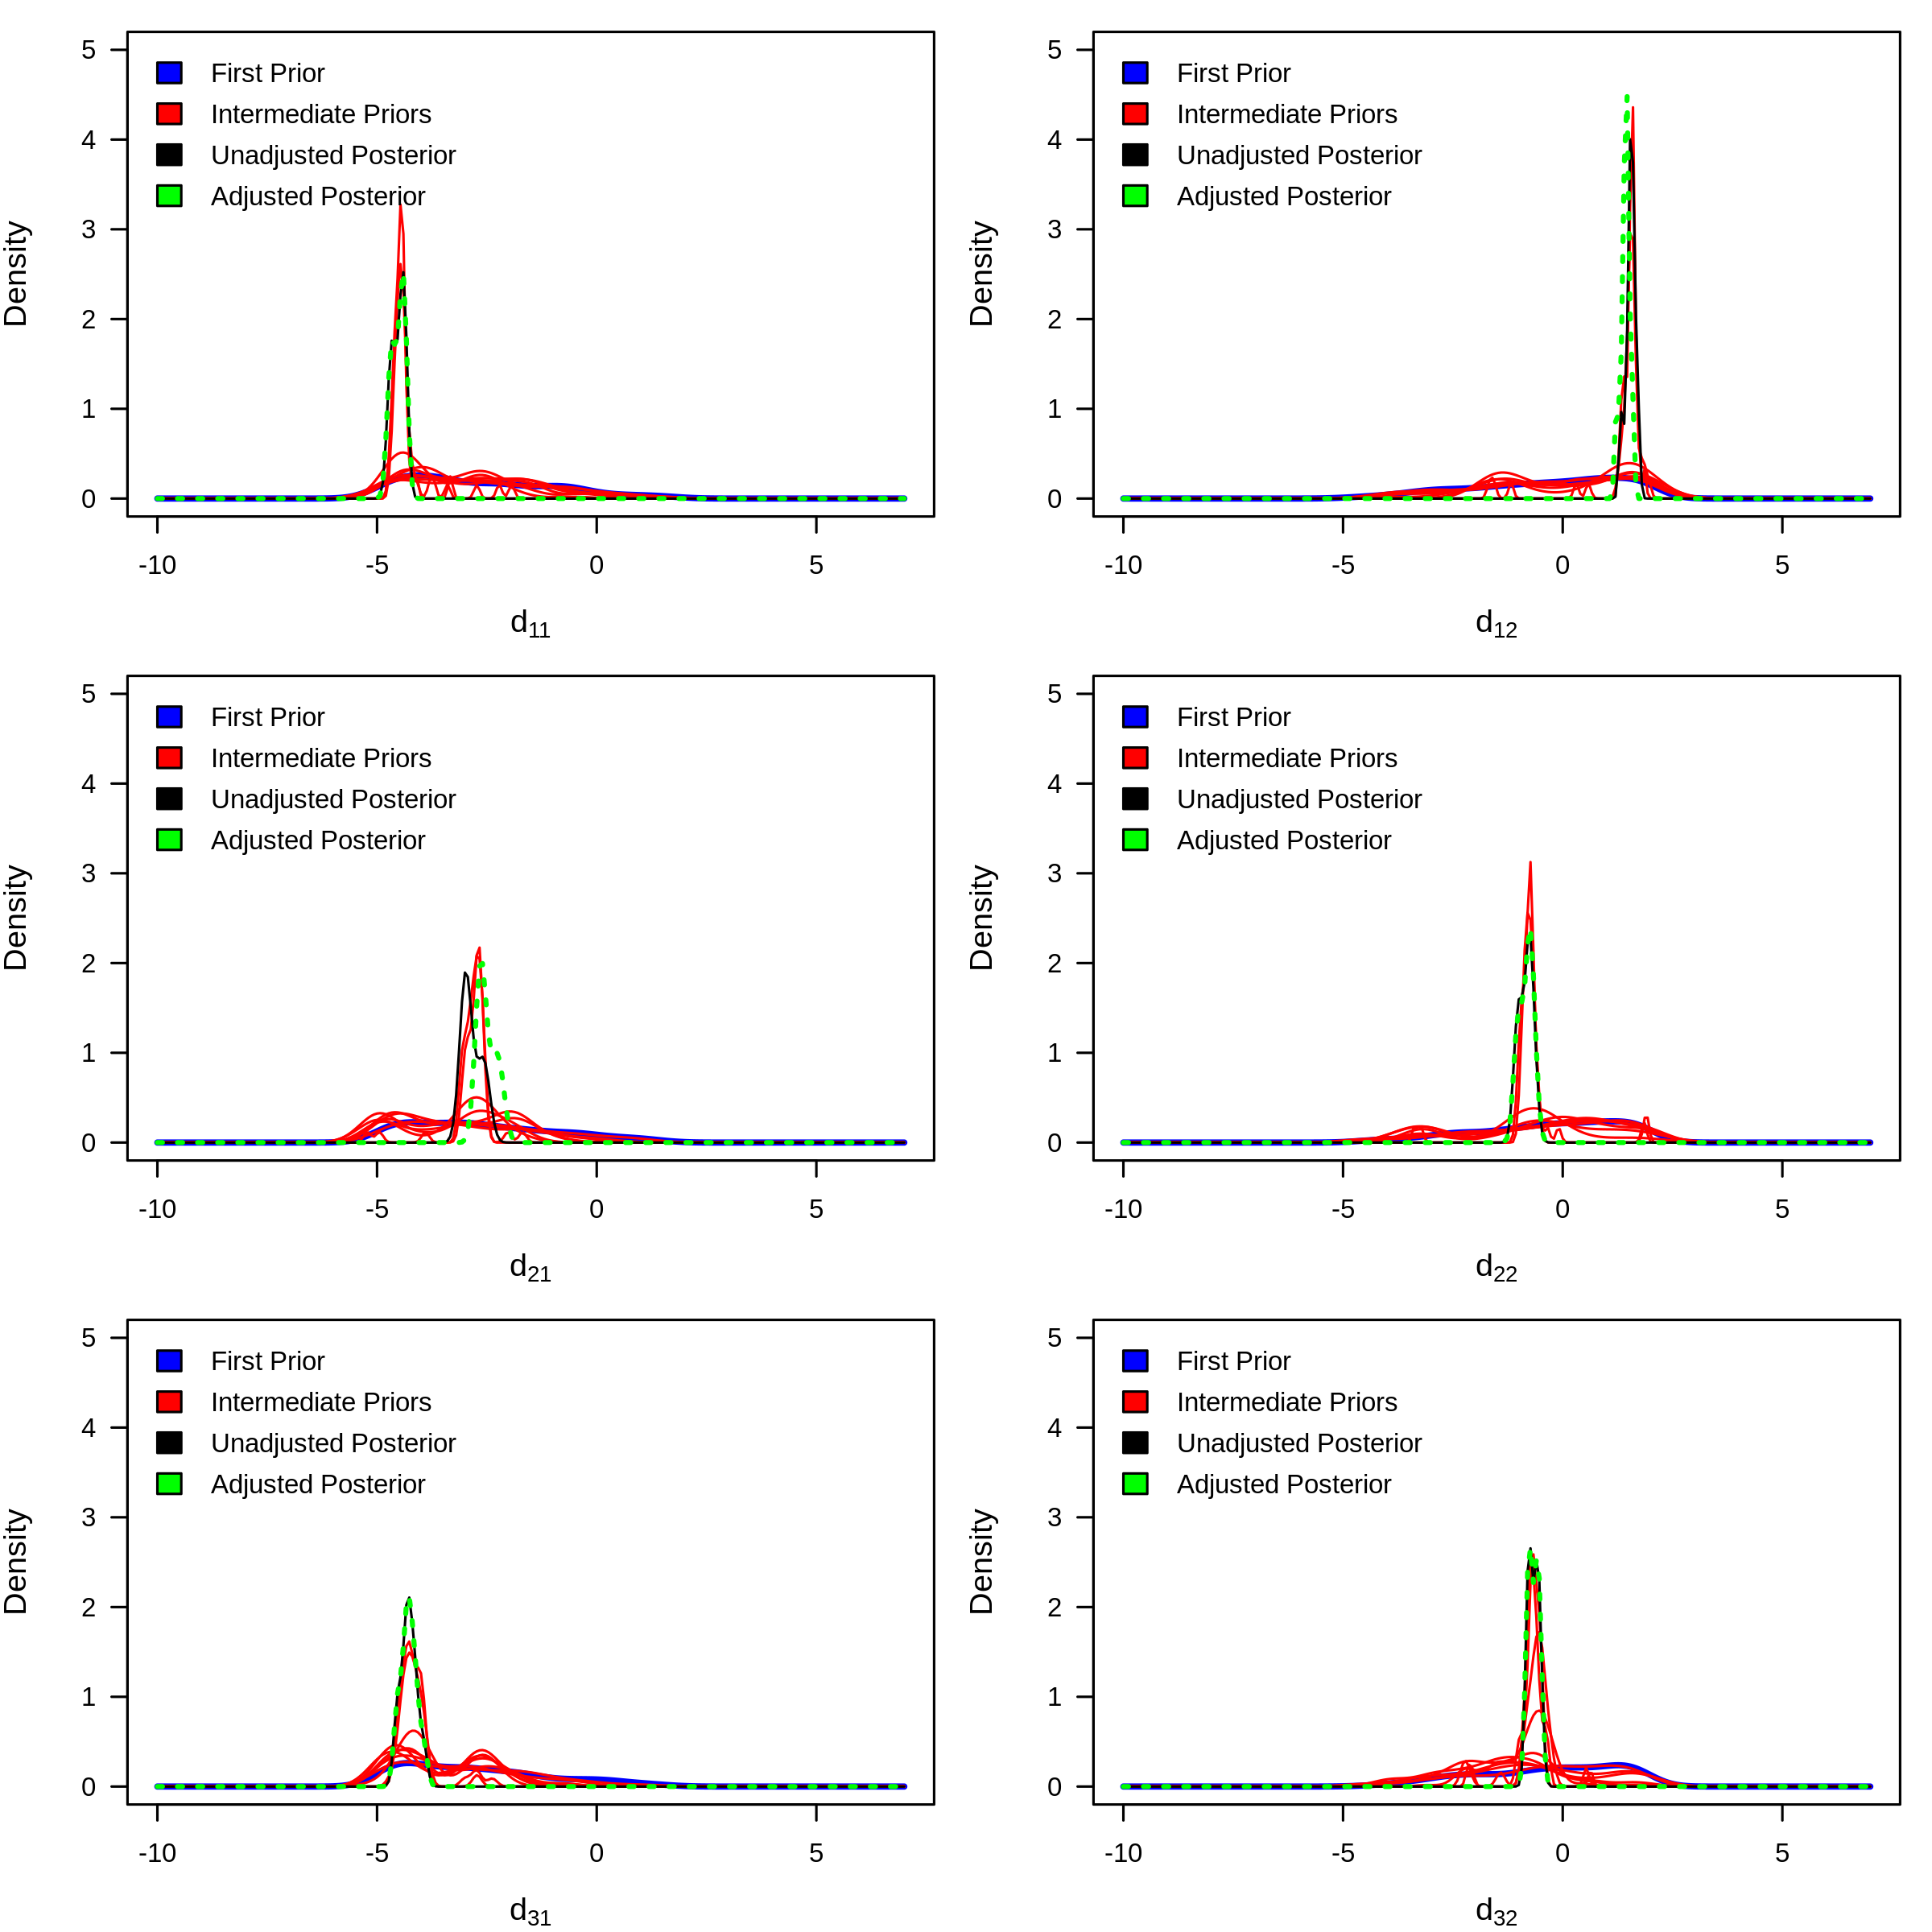

In [144]:
n=500
par(mfrow=c(3,2),mar=c(4,4,1,1))
for (k in 7:12) {
  plot(x, density_post[[n]][[1]][k, ], type="l", ylim=c(0,5),
       xlab=parameter_labels[k],ylab="Density", col="blue",cex.lab=1.2,lwd=2.5,las=1) 
  
    
  for (j in 2:10) {
    lines(x,density_post[[n]][[j]][k, ], yaxt= "n",col="red",lwd=1,pch=4,ann=FALSE,yaxt="n")
  }
    
     lines(x, density_post[[n]][[11]][k, ], col="black", lwd=1)
     lines(x,density_post_adjusted[k, ], col="green",lty=3,lwd=2)
    legend("topleft",c("First Prior","Intermediate Priors" ,"Unadjusted Posterior","Adjusted Posterior"),
         col=c("blue","red","black","green"),bty="n",cex=1,box.lwd = 2,fill=c("blue","red","black","green"))
    }
   

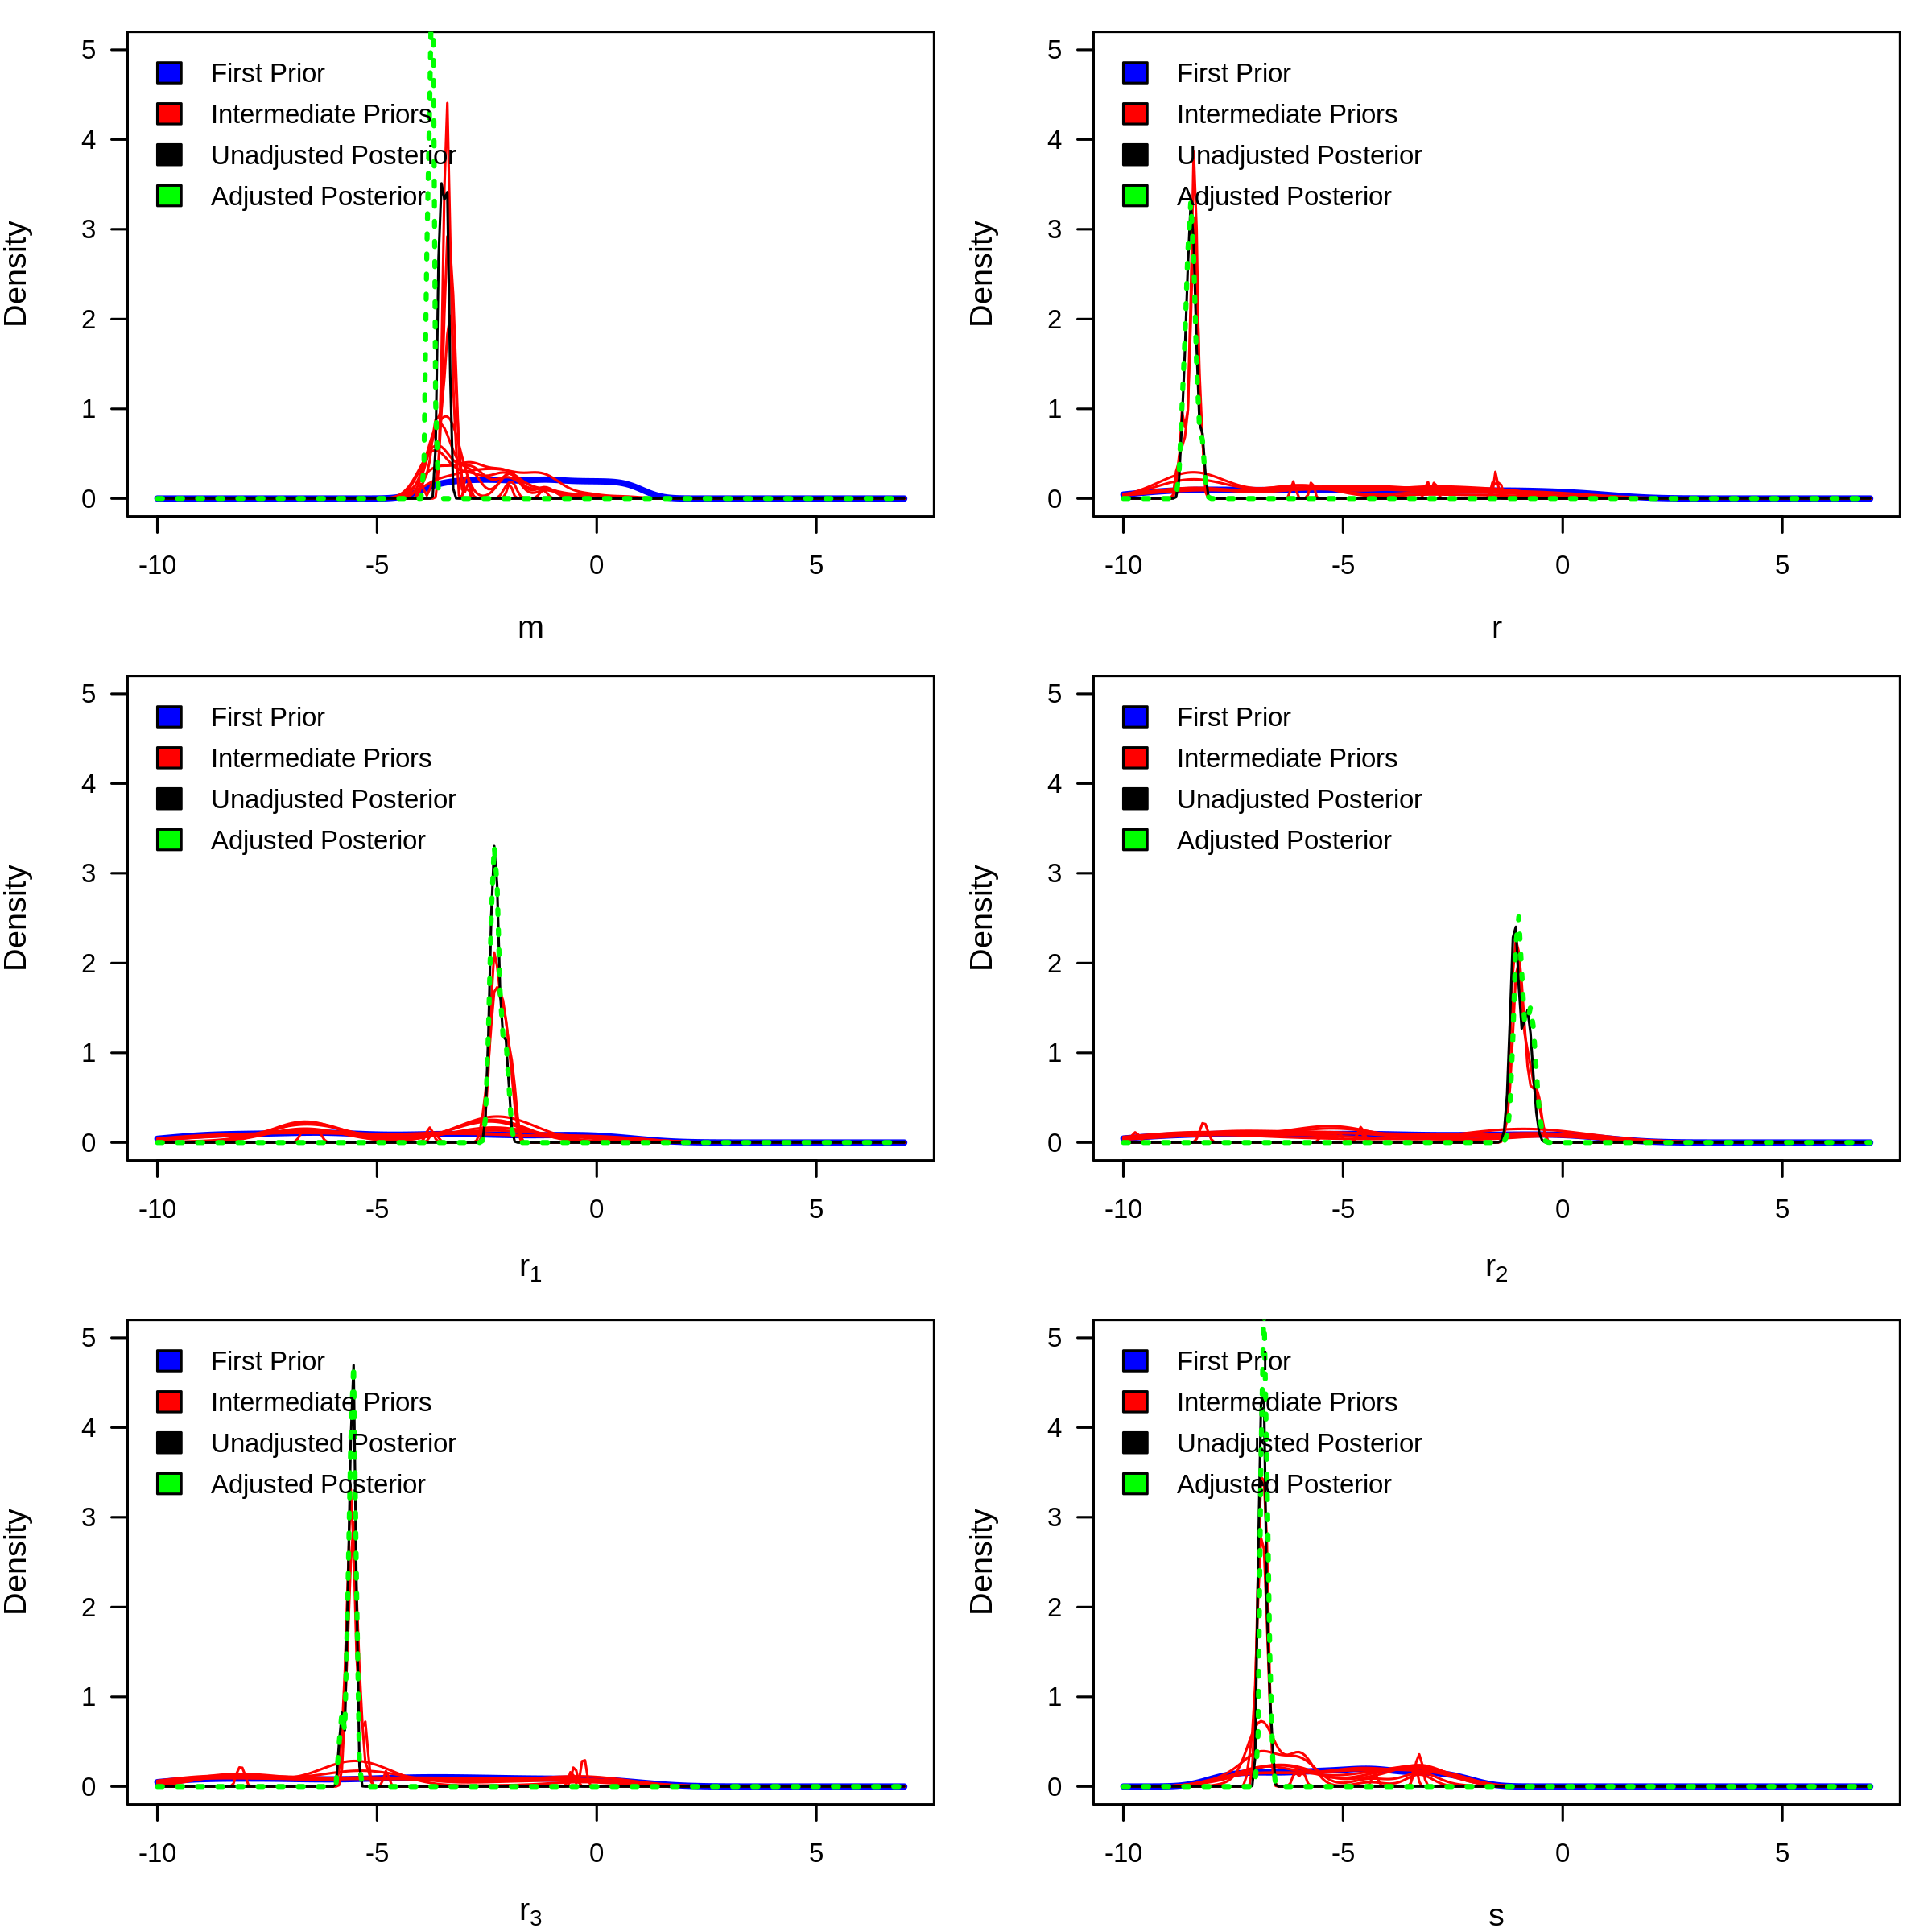

In [145]:
n=500
par(mfrow=c(3,2),mar=c(4,4,1,1))
for (k in 13:18) {
  plot(x, density_post[[n]][[1]][k, ], type="l", ylim=c(0,5),
       xlab=parameter_labels[k],ylab="Density", col="blue",cex.lab=1.2,lwd=2.5,las=1) 
  
    
  for (j in 2:10) {
    lines(x,density_post[[n]][[j]][k, ], yaxt= "n",col="red",lwd=1,pch=4,ann=FALSE,yaxt="n")
  }
    
     lines(x, density_post[[n]][[11]][k, ], col="black", lwd=1)
     lines(x,density_post_adjusted[k, ], col="green",lty=3,lwd=2)
    legend("topleft",c("First Prior","Intermediate Priors" ,"Unadjusted Posterior","Adjusted Posterior"),
         col=c("blue","red","black","green"),bty="n",cex=1,box.lwd = 2,fill=c("blue","red","black","green"))
    }
   

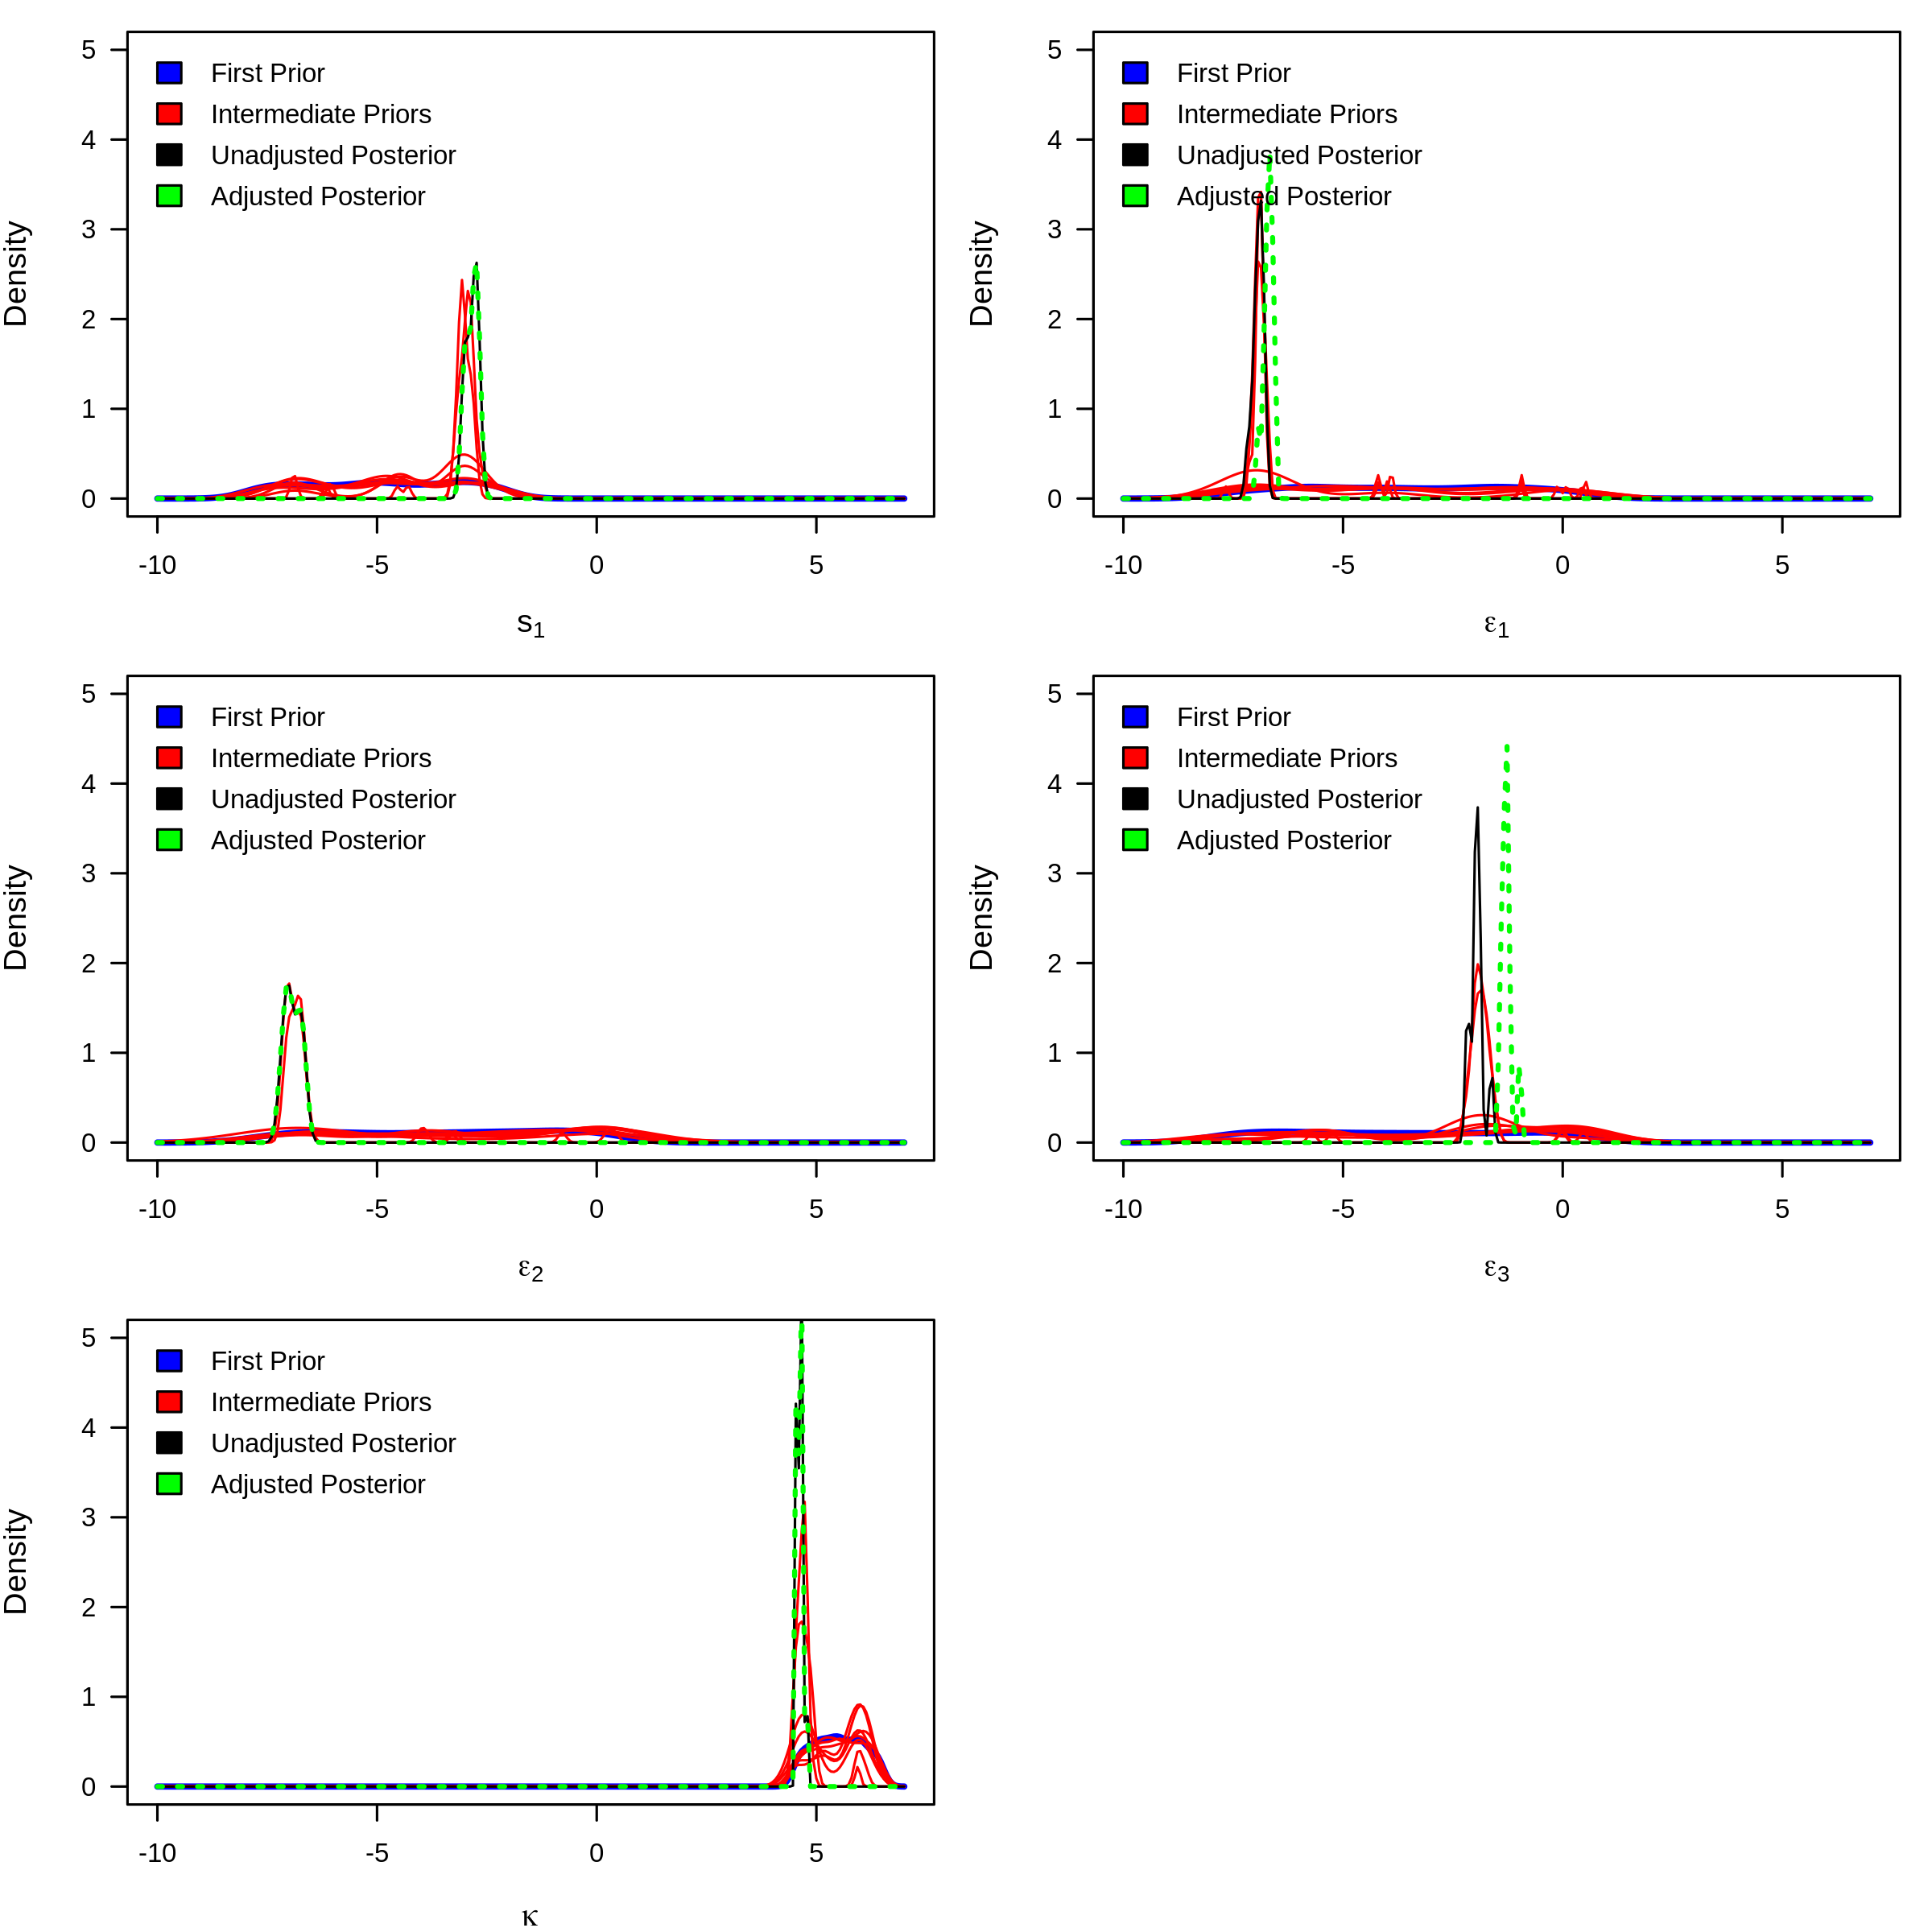

In [146]:
n=500
par(mfrow=c(3,2),mar=c(4,4,1,1))
for (k in 19:23) {
  plot(x, density_post[[n]][[1]][k, ], type="l", ylim=c(0,5),
       xlab=parameter_labels[k],ylab="Density", col="blue",cex.lab=1.2,lwd=2.5,las=1) 
  
    
  for (j in 2:10) {
    lines(x,density_post[[n]][[j]][k, ], yaxt= "n",col="red",lwd=1,pch=4,ann=FALSE,yaxt="n")
  }
    
     lines(x, density_post[[n]][[11]][k, ], col="black", lwd=1)
     lines(x,density_post_adjusted[k, ], col="green",lty=3,lwd=2)
    legend("topleft",c("First Prior","Intermediate Priors" ,"Unadjusted Posterior","Adjusted Posterior"),
         col=c("blue","red","black","green"),bty="n",cex=1,box.lwd = 2,fill=c("blue","red","black","green"))
    }
   

# Hypothesis testing